# Geospatial ML - Random distributed points, a mining example

This tutorial was written originally by Thomas Ostersen and Tom Carmichael of [Datarock](https://datarock.com.au/) for Transform 2022 conference. I thank them for putting togther this tutorial and sharing it, under an open license. Please give all kudos to them :)

### Changes and Spirit

Small changes will be done shorten and lightly edit where I see fit. Some addtional analysis will also be added. If you are interested in the original work, please check out the repo below. The science and findings should be extremely similar as the original work.

### Orignal Repo

is [here](https://github.com/Solve-Geosolutions/transform_2022)

### Original Data License

All data presented in this tutorial were derived from open data sets made available through [Mineral Resources Tasmania](https://www.mrt.tas.gov.au/) and [Geoscience Australia](https://www.ga.gov.au/).

**LICENSE CONDITIONS**

By exporting this data you accept and comply with the terms and conditions set out below:

[Creative Commons Attribution 3.0 Australia](https://creativecommons.org/licenses/by/3.0/au/)

<img src="assets/creative_commons_logo.png" />

# Why This Mining Geology Example?

This is a great example of how we need to account for [spatial autocorrelation](https://www.paulamoraga.com/book-spatial/spatial-autocorrelation.html#) (another reference [here](https://mgimond.github.io/Spatial/spatial-autocorrelation.html)) for machine learning projects. Rocks generally (but not always!) are not time dependent. I would not necessairly use the same methods for time dependent weather/climate datasets.

# Geologic Background:

## Study Area: Northeastern Tasmania

* Oldest rocks belong to thick package of folded Ordovician Mathinna Supergroup sediments
* These extensively intruded by granitoids in the Devonian
* Study area is prospective for intrusion related tin-tungsten and gold mineralisation

<img src="assets/hong_et_al_2019_tasgeomap.png" style="width: 800px" />

<center>Figure modifed from <a href=https://doi.org/10.2138/am-2019-6534>Hong et al, (2019)</a></center>

## Download Data Sets

  1. Download the zipped data set from our thredds server
  2. Unzip the data directory
  

In [1]:
import requests
import zipfile
from io import BytesIO
import os

In [2]:
def download_and_unzip(url, extract_to='geodata'):
    """
    Downloads a zip file from the provided URL and extracts it to the specified folder.
    Overwrites existing files in the target directory without prompting.
    """
    print(f"Downloading and extracting from {url}...")

    # Check if directory exists and notify
    if os.path.exists(extract_to):
        print(f"Folder '{extract_to}' already exists. Files will be overwritten.")

    # Create the directory if it doesn't exist
    os.makedirs(extract_to, exist_ok=True)

    response = requests.get(url)
    if response.status_code == 200:
        z = zipfile.ZipFile(BytesIO(response.content))
        z.extractall(extract_to)
        print(f"Successfully extracted {len(z.namelist())} files to {extract_to}/")
        return z.namelist()
    else:
        print(f"Download failed with status code: {response.status_code}")

In [3]:
files = download_and_unzip("https://thredds-test.unidata.ucar.edu/thredds/fileServer/casestudies/ml_case_study_data/tas_sn_w_datasets.zip")

Successfully extracted 8 files to geodata/


You might need to add these two packages to your enviroment:

In [4]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 57.1 MB/s eta 0:00:00


In [5]:
!pip install torchinfo

In [6]:
# Base data manipulation
import numpy as np
import pandas as pd
from typing import Dict, List, Optional, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import seaborn as sns

# Geospatial data processing
import geopandas as gpd
import rasterio
from rasterio.features import rasterize

# Scientific computing
from scipy import ndimage
from scipy.interpolate import griddata

# Machine learning - scikit-learn
from sklearn.metrics import (
    auc,
    f1_score,
    jaccard_score,
    precision_score,
    recall_score,
    roc_curve,
)

# Deep learning - PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.distributed import DistributedSampler

from torchinfo import summary

# Image processing
from PIL import Image

# Progress tracking
from tqdm import tqdm
from tqdm.notebook import tqdm as notebook_tqdm, trange

In [7]:
# set some plotting parameters
mpl.rcParams.update({"axes.grid":True, "grid.color":"gray", "grid.linestyle":'--','figure.figsize':(10,10)})

## Pointing to our data directory

In [8]:
data_dir = 'geodata/'

# set path to minoccs
point_fn = os.path.join(data_dir, 'sn_w_minoccs.gpkg')

# make a list of rasters in the data directory
geotiffs = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if '.tif' in x]
point_fn, geotiffs

('geodata/sn_w_minoccs.gpkg',
 ['geodata/tasgrav_IR.tif',
  'geodata/tasmag_TMI_1VD.tif',
  'geodata/tasrad_K_pct.tif',
  'geodata/tasmag_TMI.tif',
  'geodata/tasrad_U_ppm.tif',
  'geodata/tasgrav_IR_1VD.tif',
  'geodata/tasrad_Th_ppm.tif'])

First cut at plotting, where do we have occurances

<Axes: >

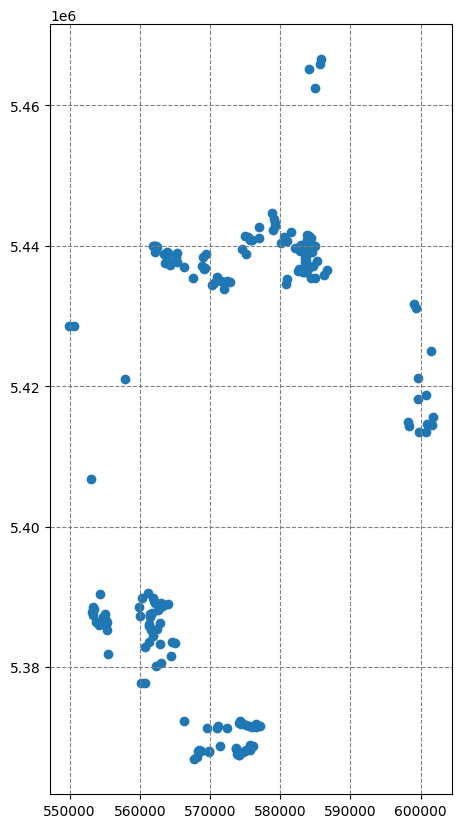

In [9]:
df = gpd.read_file(point_fn)
df.plot()

### Reading in GeoTiffs

In [10]:
# read geotiffs
data, names = [], []  # Lists to store data and corresponding file names
for fn in geotiffs:  # Loop through each GeoTIFF file
    with rasterio.open(fn, 'r') as src:  # Open GeoTIFF file for reading
        # read spatial information
        transform = src.transform  # Get affine transformation matrix
        region = (src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3])  # Get bounding box coordinates (left, bottom, right, top)
        # read band 1 data
        d = src.read(1)  # Read data from the first band
        nodata_mask = d == src.nodata  # Create a mask for NoData values
        d[nodata_mask] = np.nan  # Replace NoData values with NaN
        # append data to lists
        data.append(d)  # Append data to the list
        names.append(os.path.basename(fn).replace('.tif',''))  # Append file name to the list (without extension)

# stack list into 3D numpy array
data = np.stack(data)  # Stack the list of arrays into a 3D numpy array
data.shape, names  # Return the shape of the data array and the list of file names

((7, 2633, 1876),
 ['tasgrav_IR',
  'tasmag_TMI_1VD',
  'tasrad_K_pct',
  'tasmag_TMI',
  'tasrad_U_ppm',
  'tasgrav_IR_1VD',
  'tasrad_Th_ppm'])

In [11]:
entire_input_ds = data

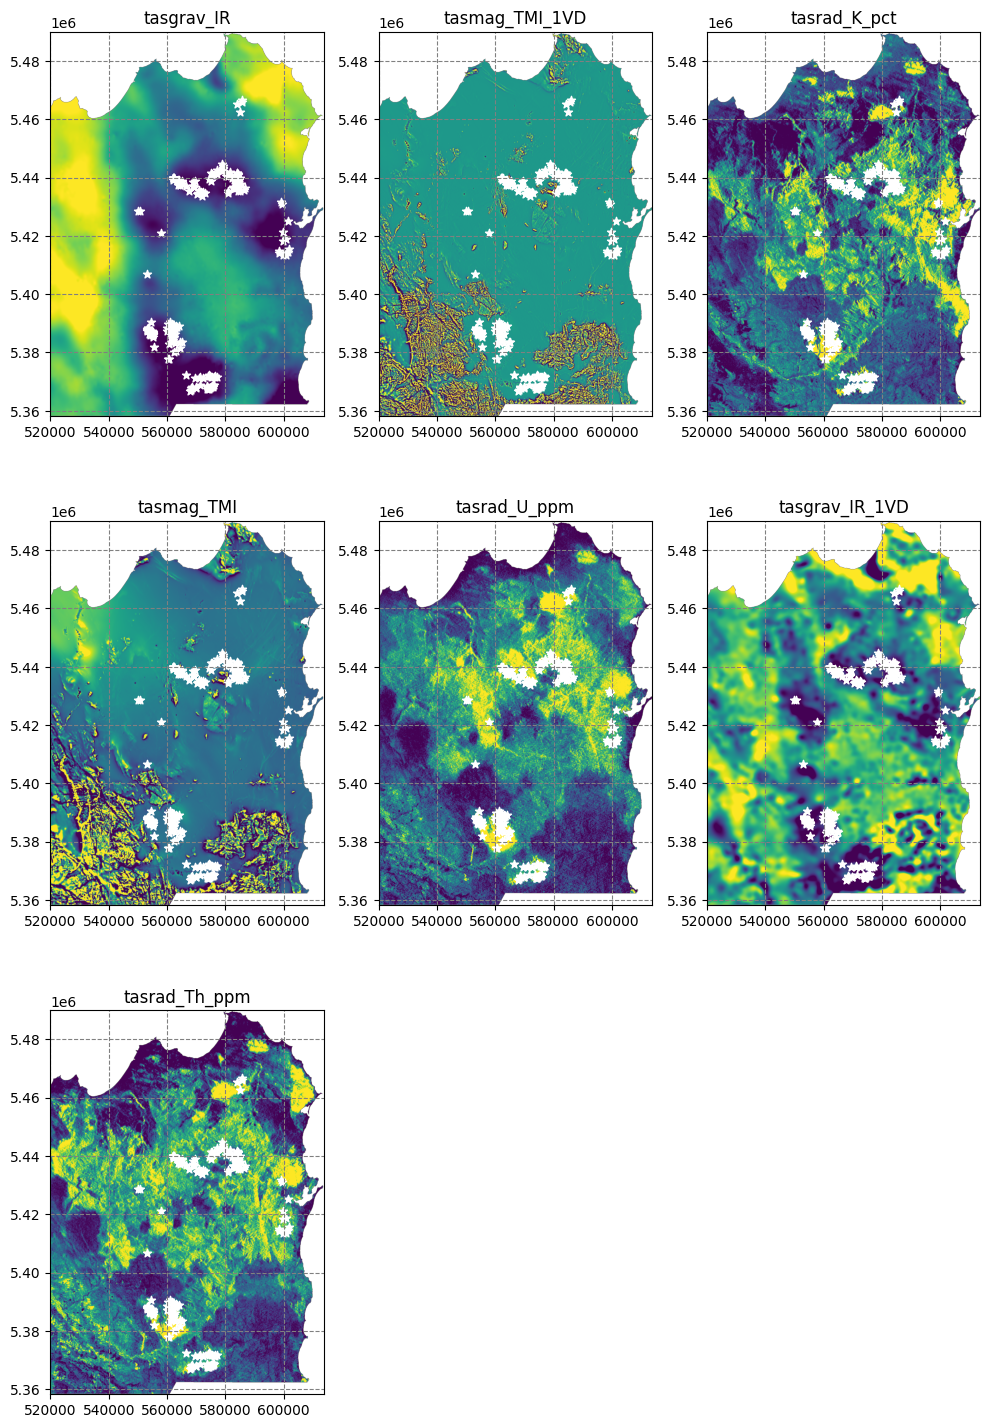

In [12]:
# plot the data
fig, axes = plt.subplots(3,3,figsize=(12,18))
for i, ax in enumerate(axes.flatten()):
    if i < data.shape[0]:
        ax.imshow(data[i], vmin=np.nanpercentile(data[i], 5), vmax=np.nanpercentile(data[i], 95), extent=region)
        ax.set(title=names[i])
        df.plot(ax=ax, marker='*', facecolor='w')
    else:
        ax.axis('off')
plt.show()

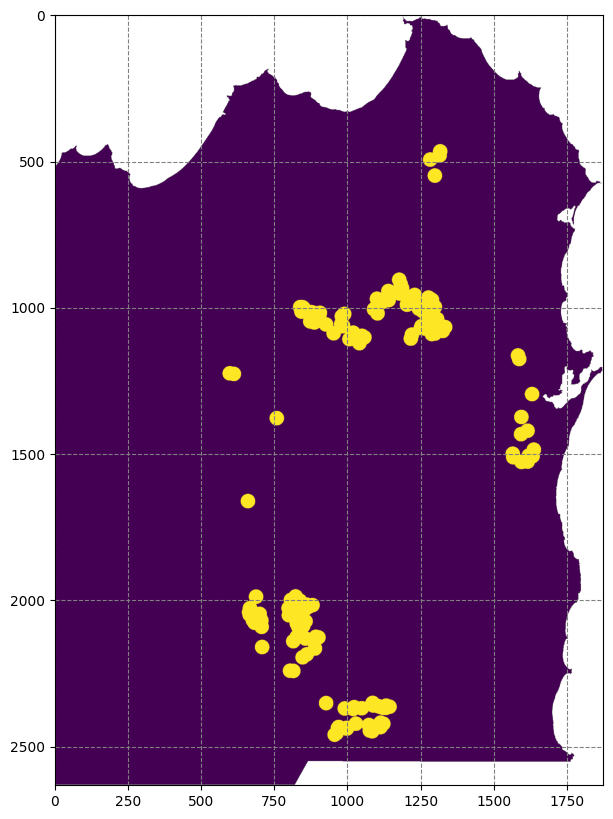

In [13]:
# rasterize the point
geometry_generator = ((geom, 1) for geom in df.buffer(1250).geometry)
labels = rasterize(shapes=geometry_generator, out_shape=data[0].shape, fill=0, transform=transform).astype('float32')
labels[nodata_mask] = np.nan

plt.imshow(labels)

## Data Engineering for UNET's

In [14]:
def split_data_by_y_coordinate(data, labels, y_threshold=1800):
    """
    Split data and labels by y-coordinate threshold for train/test split.

    Parameters:
    -----------
    data : np.ndarray
        Input data with shape (channels, height, width)
    labels : np.ndarray
        Labels with shape (height, width)
    y_threshold : int
        Y-coordinate threshold for splitting (y ≤ threshold will be training)

    Returns:
    --------
    train_data : np.ndarray
        Training data with shape (channels, height_train, width)
    train_labels : np.ndarray
        Training labels with shape (height_train, width)
    test_data : np.ndarray
        Test data with shape (channels, height_test, width)
    test_labels : np.ndarray
        Test labels with shape (height_test, width)
    """
    # Split the data at the y-threshold
    train_data = data[:, :y_threshold, :]  # Takes rows 0-1800
    train_labels = labels[:y_threshold, :]

    test_data = data[:, y_threshold:, :]   # Takes rows 1801-2633
    test_labels = labels[y_threshold:, :]

    return train_data, train_labels, test_data, test_labels

In [15]:
train_data, train_labels, test_data, test_labels = split_data_by_y_coordinate(data, labels, y_threshold=1800)

In [16]:
def extract_and_interpolate_patches_for_pytorch(
    data: np.ndarray,
    labels: np.ndarray,
    patch_size: int = 64,
    stride: int = 16,
    valid_threshold: float = 0.5,
    show_progress: bool = True,
    augmentation: bool = False
) -> Tuple[np.ndarray, np.ndarray, List[Tuple[int, int]]]:
    """
    Extract patches with at least threshold% valid data, interpolate NaN values,
    and return arrays formatted for PyTorch conversion.

    Includes label statistics to diagnose issues with missing positive values.

    Parameters:
    -----------
    data: np.ndarray
        Input data with shape (channels, height, width)
    labels: np.ndarray
        Input labels with shape (height, width)
    patch_size: int
        Size of the patches to extract
    stride: int
        Stride between patches
    valid_threshold: float
        Minimum percentage of valid (non-NaN) values required in a patch
    show_progress: bool
        Whether to show a progress bar
    augmentation: bool
        Whether to apply all unique augmentations to each patch:
        - 90° rotation
        - 180° rotation
        - 270° rotation
        - Horizontal flip
        - Vertical flip
        (Note: 180° rotation is equivalent to horizontal+vertical flip, so the latter is not included)

    Returns:
    --------
    patches_data: np.ndarray
        Extracted and processed data patches
    patches_labels: np.ndarray
        Extracted and processed label patches
    patch_indices: List[Tuple[int, int]]
        Indices of the top-left corner of each patch in the original image
    """
    patches_data, patches_labels, patch_indices = [], [], []
    channels, h, w = data.shape
    total_patches = ((h - patch_size + 1) // stride) * ((w - patch_size + 1) // stride)
    valid_patches = 0

    # Print original label statistics
    print("Original Label Statistics:")
    non_nan_mask = ~np.isnan(labels)
    if np.any(non_nan_mask):
        unique_values, counts = np.unique(labels[non_nan_mask], return_counts=True)
        print(f"  Unique values: {unique_values}")
        print(f"  Counts: {counts}")
        positive_pixels = np.sum(labels[non_nan_mask] > 0)
        total_non_nan_pixels = np.sum(non_nan_mask)
        print(f"  Positive pixels: {positive_pixels} out of {total_non_nan_pixels} ({positive_pixels/total_non_nan_pixels*100:.4f}%)")
    else:
        print("  All values are NaN in the original labels!")

    # Create reusable coordinate grid for interpolation
    coords = np.stack(np.meshgrid(np.arange(patch_size), np.arange(patch_size), indexing='ij'), axis=-1).reshape(-1, 2)

    # Create iterator with optional progress bar
    row_iterator = tqdm(range(0, h - patch_size + 1, stride), desc="Extracting patches") if show_progress else range(0, h - patch_size + 1, stride)

    # Count patches with positive labels
    patches_with_positives = 0

    for i in row_iterator:
        for j in range(0, w - patch_size + 1, stride):
            # Extract patch
            patch_data = data[:, i:i+patch_size, j:j+patch_size].copy()
            patch_label = labels[i:i+patch_size, j:j+patch_size].copy()

            # Check if patch has enough valid data
            if (1 - np.isnan(patch_label).mean()) >= valid_threshold:
                # Process each channel
                for c in range(channels):
                    channel = patch_data[c]
                    mask = np.isnan(channel)

                    if np.all(mask):
                        # If entire channel is NaN, set to 0
                        channel[mask] = 0
                    elif np.any(mask):
                        # Interpolate NaNs using nearest neighbor
                        points = coords[~mask.ravel()]
                        values = channel[~mask]
                        points_to_interp = coords[mask.ravel()]

                        if len(points) > 0 and len(points_to_interp) > 0:
                            interp_values = griddata(points, values, points_to_interp, method='nearest')
                            channel.flat[np.where(mask.ravel())[0]] = interp_values

                # For binary labels, simply fill NaN values with 0
                mask = np.isnan(patch_label)
                if np.any(mask):
                    patch_label[mask] = 0  # Set all NaN values in labels to 0

                # Count if this patch has any positive labels
                if np.any(patch_label > 0):
                    patches_with_positives += 1

                # Add the original patch
                patches_data.append(patch_data)
                patches_labels.append(patch_label)
                patch_indices.append((i, j))
                valid_patches += 1

                # Add augmented versions if augmentation is enabled
                if augmentation:
                    # Rotate by 90 degrees
                    patch_data_90 = np.array([np.rot90(channel, k=1) for channel in patch_data])
                    patch_label_90 = np.rot90(patch_label, k=1)
                    patches_data.append(patch_data_90)
                    patches_labels.append(patch_label_90)
                    patch_indices.append((i, j))

                    # Rotate by 180 degrees
                    patch_data_180 = np.array([np.rot90(channel, k=2) for channel in patch_data])
                    patch_label_180 = np.rot90(patch_label, k=2)
                    patches_data.append(patch_data_180)
                    patches_labels.append(patch_label_180)
                    patch_indices.append((i, j))

                    # Rotate by 270 degrees
                    patch_data_270 = np.array([np.rot90(channel, k=3) for channel in patch_data])
                    patch_label_270 = np.rot90(patch_label, k=3)
                    patches_data.append(patch_data_270)
                    patches_labels.append(patch_label_270)
                    patch_indices.append((i, j))

                    # Horizontal flip (mirror across y-axis)
                    patch_data_h = np.array([np.flip(channel, axis=1) for channel in patch_data])
                    patch_label_h = np.flip(patch_label, axis=1)
                    patches_data.append(patch_data_h)
                    patches_labels.append(patch_label_h)
                    patch_indices.append((i, j))

                    # Vertical flip (mirror across x-axis)
                    patch_data_v = np.array([np.flip(channel, axis=0) for channel in patch_data])
                    patch_label_v = np.flip(patch_label, axis=0)
                    patches_data.append(patch_data_v)
                    patches_labels.append(patch_label_v)
                    patch_indices.append((i, j))

                    # Note: We don't include horizontal+vertical flip since it's
                    # equivalent to 180° rotation which is already included

    # Convert to numpy arrays with proper format for PyTorch
    if patches_data:
        patches_data = np.array(patches_data, dtype=np.float32)
        patches_labels = np.array(patches_labels, dtype=np.float32).reshape(-1, 1, patch_size, patch_size)
    else:
        patches_data = np.empty((0, channels, patch_size, patch_size), dtype=np.float32)
        patches_labels = np.empty((0, 1, patch_size, patch_size), dtype=np.float32)

    # Print patch statistics
    invalid_patches = total_patches - valid_patches
    print(f"\nPatch Statistics:")
    print(f"  Total patches examined: {total_patches}")
    print(f"  Valid patches (≥{valid_threshold*100}% non-NaN values): {valid_patches} ({valid_patches/total_patches*100:.2f}%)")
    print(f"  Invalid patches (<{valid_threshold*100}% non-NaN values): {invalid_patches} ({invalid_patches/total_patches*100:.2f}%)")

    # Calculate and report augmentation statistics
    total_exported = len(patches_data)
    augmented_patches = total_exported - valid_patches if augmentation else 0

    print(f"  Number of original patches: {valid_patches}")
    if augmentation:
        print(f"  Number of augmented patches: {augmented_patches}")
        print(f"  Augmentation types applied: 90°, 180°, 270° rotation, horizontal flip, vertical flip")
        print(f"  Multiplication factor: {total_exported/valid_patches:.1f}x (original data size)")
    print(f"  Total number of patches exported: {total_exported}")

    # Print processed label statistics
    if patches_labels.size > 0:
        print("\nProcessed Label Statistics:")
        unique_values, counts = np.unique(patches_labels, return_counts=True)
        print(f"  Unique values: {unique_values}")
        print(f"  Counts: {counts}")
        positive_pixels = np.sum(patches_labels > 0)
        total_pixels = patches_labels.size
        print(f"  Positive pixels: {positive_pixels} out of {total_pixels} ({positive_pixels/total_pixels*100:.4f}%)")

        # Calculate patches with positive pixels (may include augmented patches)
        patches_with_positives_total = np.sum(np.any(patches_labels.reshape(len(patches_labels), -1) > 0, axis=1))
        print(f"  Patches with positive pixels: {patches_with_positives_total} out of {len(patches_labels)} ({patches_with_positives_total/len(patches_labels)*100:.2f}%)")

        # Warning for no positive values
        if positive_pixels == 0:
            print("\n⚠️ WARNING: Your processed labels contain NO positive values! ⚠️")
            print("This will prevent your model from learning to identify positive regions.")
            print("Possible solutions:")
            print("1. Check if your original labels contain positive values")
            print("2. Ensure your thresholding process (if any) is working correctly")
            print("3. Consider using a different patch extraction strategy to include positive regions")

    return patches_data, patches_labels, patch_indices

In [17]:
stride_size = 16

# Process TRAINING data with augmentation
print("Processing TRAINING data:")
train_patches_data, train_patches_labels, train_patch_indices = extract_and_interpolate_patches_for_pytorch(
    train_data, train_labels, patch_size=64, stride=stride_size, augmentation=True)

# Process TEST data without augmentation
print("\nProcessing TEST data:")
test_patches_data, test_patches_labels, test_patch_indices = extract_and_interpolate_patches_for_pytorch(
    test_data, test_labels, patch_size=64, stride=stride_size)

Processing TRAINING data:
Original Label Statistics:
  Unique values: [0. 1.]
  Counts: [2537314   84825]
  Positive pixels: 84825 out of 2622139 (3.2350%)


Extracting patches: 100%|██████████| 109/109 [00:18<00:00,  6.02it/s]



Patch Statistics:
  Total patches examined: 12204
  Valid patches (≥50.0% non-NaN values): 9903 (81.15%)
  Invalid patches (<50.0% non-NaN values): 2301 (18.85%)
  Number of original patches: 9903
  Number of augmented patches: 49515
  Augmentation types applied: 90°, 180°, 270° rotation, horizontal flip, vertical flip
  Multiplication factor: 6.0x (original data size)
  Total number of patches exported: 59418

Processed Label Statistics:
  Unique values: [0. 1.]
  Counts: [235232928   8143200]
  Positive pixels: 8143200 out of 243376128 (3.3459%)
  Patches with positive pixels: 5976 out of 59418 (10.06%)

Processing TEST data:
Original Label Statistics:
  Unique values: [0. 1.]
  Counts: [1319686   61123]
  Positive pixels: 61123 out of 1380809 (4.4266%)


Extracting patches: 100%|██████████| 49/49 [00:03<00:00, 12.97it/s]



Patch Statistics:
  Total patches examined: 5424
  Valid patches (≥50.0% non-NaN values): 5096 (93.95%)
  Invalid patches (<50.0% non-NaN values): 328 (6.05%)
  Number of original patches: 5096
  Total number of patches exported: 5096

Processed Label Statistics:
  Unique values: [0. 1.]
  Counts: [19895248   977968]
  Positive pixels: 977968 out of 20873216 (4.6853%)
  Patches with positive pixels: 629 out of 5096 (12.34%)


#### Let's normalize this data

In [18]:
def normalize_channels_for_binary_unet(
    data: np.ndarray,
    calculate_stats: bool = True,
    stats: Optional[Dict[int, Dict[str, float]]] = None,
    show_progress: bool = True,
    epsilon: float = 1e-6  # Added epsilon parameter for numerical stability
) -> Union[np.ndarray, Tuple[np.ndarray, Dict[int, Dict[str, float]]]]:
    """
    Normalize each channel for binary U-Net classification with vectorized operations.

    Parameters:
    -----------
    data : np.ndarray
        Input data with shape (n_patches, channels, patch_height, patch_width)
    calculate_stats : bool, optional
        Whether to calculate statistics (True for training, False for test data)
    stats : Dict[int, Dict[str, float]], optional
        Dictionary with mean/std values (required when calculate_stats is False)
    show_progress : bool, optional
        Whether to display a progress bar during normalization
    epsilon : float, optional
        Small constant added to standard deviation for numerical stability

    Returns:
    --------
    normalized_data : np.ndarray
        Data with each channel normalized
    stats : Dict[int, Dict[str, float]], optional
        Dictionary with mean/std values (only returned when calculate_stats is True)
    """
    # Extract dimensions and validate inputs
    _, n_channels, *_ = data.shape
    print(f"Processing data with {n_channels} channels")
    if not calculate_stats and stats is None:
        raise ValueError("Stats must be provided when calculate_stats is False")

    # Print statistics for each channel before normalization
    print("\n--- Channel Statistics Before Normalization ---")
    for c in range(n_channels):
        channel_data = data[:, c].flatten()
        print(f"Channel {c}: min={np.nanmin(channel_data):.3f}, max={np.nanmax(channel_data):.3f}, "
              f"mean={np.nanmean(channel_data):.3f}, median={np.nanmedian(channel_data):.3f}")

    # Preallocate output array with same shape and float32 type
    normalized_data = np.zeros_like(data, dtype=np.float32)
    computed_stats: Dict[int, Dict[str, float]] = {}

    if calculate_stats:
        # Reshape and compute stats for all channels at once (vectorized)
        reshaped_data = data.transpose(1, 0, 2, 3).reshape(n_channels, -1)
        means = np.nanmean(reshaped_data, axis=1)
        stds = np.maximum(np.nanstd(reshaped_data, axis=1), epsilon)  # Apply epsilon for stability

        # Build stats dictionary and normalize
        iterator = tqdm(range(n_channels), desc="Building stats") if show_progress else range(n_channels)
        for c in iterator:
            computed_stats[c] = {'mean': float(means[c]), 'std': float(stds[c])}
    else:
        # Use pre-computed statistics
        assert stats is not None  # For type checker
        means = np.array([stats[c]['mean'] for c in range(n_channels)])
        stds = np.array([stats[c]['std'] for c in range(n_channels)])

    # Normalize all channels
    for c in tqdm(range(n_channels), desc="Normalizing") if show_progress else range(n_channels):
        normalized_data[:, c] = (data[:, c] - means[c]) / stds[c]

    # Print statistics for each channel after normalization
    print("\n--- Channel Statistics After Normalization ---")
    for c in range(n_channels):
        channel_data = normalized_data[:, c].flatten()
        print(f"Channel {c}: min={np.nanmin(channel_data):.3f}, max={np.nanmax(channel_data):.3f}, "
              f"mean={np.nanmean(channel_data):.3f}, median={np.nanmedian(channel_data):.3f}")

    print(f"Final normalized data shape: {normalized_data.shape}")
    return (normalized_data, computed_stats) if calculate_stats else normalized_data

In [19]:
# Normalize training data and get statistics
train_patches_normalized, norm_stats = normalize_channels_for_binary_unet(train_patches_data, calculate_stats=True)

print("\nProcessing TEST data:")
# Apply same normalization to test data
test_patches_normalized = normalize_channels_for_binary_unet(
    test_patches_data,
    calculate_stats=False,
    stats=norm_stats
)

# Make sure labels are binary (0 or 1)
# Check if we're dealing with PyTorch tensors or NumPy arrays
if isinstance(train_patches_labels, torch.Tensor):
    # Use PyTorch methods for tensors
    train_patches_labels = (train_patches_labels > 0).to(torch.float32)
    test_patches_labels = (test_patches_labels > 0).to(torch.float32)
else:
    # Use NumPy methods for arrays
    train_patches_labels = (train_patches_labels > 0).astype(np.float32)
    test_patches_labels = (test_patches_labels > 0).astype(np.float32)

Processing data with 7 channels

--- Channel Statistics Before Normalization ---
Channel 0: min=-525.749, max=2294.860, mean=-155.330, median=-159.314
Channel 1: min=-21.784, max=50.318, mean=-0.001, median=-0.003
Channel 2: min=-0.563, max=4.176, mean=0.871, median=0.778
Channel 3: min=-2362.806, max=4588.527, mean=-28.680, median=-44.327
Channel 4: min=-0.709, max=9.821, mean=1.593, median=1.548
Channel 5: min=-49847.531, max=336924.656, mean=-17.300, median=49.636
Channel 6: min=-0.426, max=43.514, mean=7.471, median=7.493


Normalizing: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]



--- Channel Statistics After Normalization ---
Channel 0: min=-5.392, max=35.667, mean=0.000, median=-0.058
Channel 1: min=-47.210, max=109.056, mean=0.000, median=-0.005
Channel 2: min=-2.681, max=6.180, mean=0.000, median=-0.174
Channel 3: min=-28.708, max=56.788, mean=0.000, median=-0.192
Channel 4: min=-3.292, max=11.767, mean=-0.000, median=-0.064
Channel 5: min=-50.034, max=338.323, mean=-0.000, median=0.067
Channel 6: min=-2.294, max=10.469, mean=0.000, median=0.006
Final normalized data shape: (59418, 7, 64, 64)

Processing TEST data:
Processing data with 7 channels

--- Channel Statistics Before Normalization ---
Channel 0: min=-359.978, max=-22.598, mean=-181.433, median=-175.252
Channel 1: min=-20.849, max=38.208, mean=-0.001, median=-0.010
Channel 2: min=-0.148, max=4.737, mean=0.783, median=0.695
Channel 3: min=-2104.979, max=4813.387, mean=-18.699, median=-57.950
Channel 4: min=-0.690, max=13.529, mean=1.279, median=1.100
Channel 5: min=-4840.706, max=4294.108, mean=-136

Normalizing: 100%|██████████| 7/7 [00:00<00:00, 12.97it/s]



--- Channel Statistics After Normalization ---
Channel 0: min=-2.979, max=1.932, mean=-0.380, median=-0.290
Channel 1: min=-45.186, max=82.809, mean=-0.001, median=-0.020
Channel 2: min=-1.905, max=7.228, mean=-0.164, median=-0.329
Channel 3: min=-25.537, max=59.554, mean=0.123, median=-0.360
Channel 4: min=-3.265, max=17.071, mean=-0.449, median=-0.705
Channel 5: min=-4.843, max=4.329, mean=-0.120, median=0.080
Channel 6: min=-2.706, max=15.004, mean=-0.278, median=-0.490
Final normalized data shape: (5096, 7, 64, 64)


## Train Models

In [20]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, use_batchnorm=True, dropout_rate=0.0):
        super().__init__()
        mid_channels = mid_channels or out_channels  # Use out_channels as default if mid_channels not specified

        layers = []
        # First conv block
        layers += [
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=not use_batchnorm),  # 3x3 conv with padding to maintain spatial dims
            nn.BatchNorm2d(mid_channels) if use_batchnorm else nn.Identity(),  # Optional batch normalization
            nn.ReLU(inplace=True)  # Activation function
        ]
        if dropout_rate > 0:
            layers.append(nn.Dropout2d(dropout_rate))  # Add dropout to prevent overfitting

        # Second conv block
        layers += [
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=not use_batchnorm),  # 3x3 conv to get output channels
            nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity(),  # Optional batch normalization
            nn.ReLU(inplace=True)  # Activation function
        ]
        if dropout_rate > 0:
            layers.append(nn.Dropout2d(dropout_rate))  # Add dropout to prevent overfitting

        self.double_conv = nn.Sequential(*layers)  # Combine all layers into a sequential block

    def forward(self, x):
        return self.double_conv(x)  # Pass input through the double convolution


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, use_batchnorm=True, dropout_rate=0.0):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),  # Downsample spatial dimensions by factor of 2
            DoubleConv(in_channels, out_channels, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate)  # Apply convolutions after pooling
        )

    def forward(self, x):
        return self.maxpool_conv(x)  # Downsample then convolve


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False, use_batchnorm=True, dropout_rate=0.0):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # Use fixed bilinear upsampling
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2,
                                  use_batchnorm=use_batchnorm, dropout_rate=dropout_rate)  # Reduce channels in conv
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)  # Learnable upsampling
            self.conv = DoubleConv(in_channels, out_channels,
                                  use_batchnorm=use_batchnorm, dropout_rate=dropout_rate)  # Standard convolution

    def forward(self, x1, x2):
        x1 = self.up(x1)  # Upsample the input from decoder path

        # Handle size differences with padding
        diffY, diffX = x2.size()[2] - x1.size()[2], x2.size()[3] - x1.size()[3]  # Calculate size differences
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])  # Pad to match dimensions

        x = torch.cat([x2, x1], dim=1)  # Concatenate encoder and decoder features
        return self.conv(x)  # Apply convolutions to combined features


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)  # 1x1 conv to get final output channels

    def forward(self, x):
        return self.conv(x)  # Map to output channels


class UNet(nn.Module):
    def __init__(self, in_channels=7, out_channels=1, initial_features=64, bilinear=False,
                 use_batchnorm=True, dropout_rate=0.0, depth=4):
        super(UNet, self).__init__()
        self.in_channels = in_channels  # Number of input channels
        self.out_channels = out_channels  # Number of output channels
        self.bilinear = bilinear  # Type of upsampling to use
        self.depth = depth  # Number of down/up sampling operations
        factor = 2 if bilinear else 1  # Channel reduction factor for bilinear upsampling

        # Input conv block
        self.inc = DoubleConv(in_channels, initial_features, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate)  # Initial feature extraction

        # Build encoder dynamically based on depth
        self.down_blocks = nn.ModuleList()  # Store all downsampling blocks
        current_features = initial_features  # Start with initial feature count
        for i in range(depth):
            next_features = current_features * 2  # Double features at each level
            self.down_blocks.append(Down(current_features, next_features,
                                    use_batchnorm=use_batchnorm, dropout_rate=dropout_rate))  # Add downsampling block
            current_features = next_features  # Update feature count for next level

        # Build decoder dynamically based on depth
        self.up_blocks = nn.ModuleList()  # Store all upsampling blocks
        for i in range(depth):
            prev_features = current_features // 2  # Feature count from corresponding encoder level
            out_features = prev_features // factor if i < depth-1 else initial_features  # Adjust for bilinear upsampling
            self.up_blocks.append(Up(current_features, out_features,
                              bilinear=bilinear, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate))  # Add upsampling block
            current_features = prev_features  # Update feature count for next level

        # Output projection
        self.outc = OutConv(initial_features, out_channels)  # Final 1x1 conv to get output channels

    def forward(self, x):
        # Store encoder outputs for skip connections
        features = [self.inc(x)]  # Start with initial features

        # Encoder path
        for down in self.down_blocks:
            features.append(down(features[-1]))  # Apply downsampling and store result

        # Start from bottleneck
        x = features[-1]  # Get the deepest features

        # Decoder path with skip connections
        for i, up in enumerate(self.up_blocks):
            skip_index = len(features) - i - 2  # Calculate correct skip connection index
            x = up(x, features[skip_index])  # Upsample and combine with skip connection

        # Output projection (logits)
        logits = self.outc(x)  # Final 1x1 convolution
        return logits  # Return without activation (for use with BCE with logits loss)

In [21]:
# Check if GPU is available with device name and memory info
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    gpu_properties = torch.cuda.get_device_properties(device)
    print(f"Using GPU: {gpu_properties.name} with {gpu_properties.total_memory / 1e9:.2f} GB memory")
else:
    print(f"Using device: {device}")

Using GPU: NVIDIA L4 with 23.80 GB memory


In [22]:
# Enable performance optimizations
torch.backends.cudnn.benchmark = True  # Optimize for fixed input sizes (even on CPU this can help)

In [23]:
# Helper function to efficiently convert to tensor
def to_tensor(data):
    if isinstance(data, torch.Tensor):
        return data.to(torch.float32)
    return torch.tensor(data, dtype=torch.float32)

# Convert all data to tensors
train_patches_normalized = to_tensor(train_patches_normalized)
train_patches_labels = to_tensor(train_patches_labels)
test_patches_normalized = to_tensor(test_patches_normalized)
test_patches_labels = to_tensor(test_patches_labels)

# Check shapes
print(f"Train data shape: {train_patches_normalized.shape}")
print(f"Train labels shape: {train_patches_labels.shape}")

# Create datasets
train_dataset = TensorDataset(train_patches_normalized, train_patches_labels)
test_dataset = TensorDataset(test_patches_normalized, test_patches_labels)

Train data shape: torch.Size([59418, 7, 64, 64])
Train labels shape: torch.Size([59418, 1, 64, 64])


In [24]:
batch_size = 512
num_workers = min(6, os.cpu_count() // 2)  # Use half the cores for data loading

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [25]:
# Create the model (keep the sigmoid attribute but don't use it in forward)
model = UNet(in_channels=7, dropout_rate=0.25)

class FocalLoss(nn.Module):
    """Focal Loss for addressing class imbalance (Lin et al., 2017).
    Focuses training on hard examples by down-weighting easy ones."""
    def __init__(self, alpha=0.5, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        # Alpha balances positive vs negative examples - use 0.25 for rare positives
        self.alpha = alpha
        # Gamma controls focus on hard examples - standard value is 2.0
        self.gamma = gamma
        # How to aggregate the loss (mean, sum, or none)
        self.reduction = reduction
        # Use BCE with logits for improved numerical stability
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        # Compute binary cross entropy as the base loss
        bce_loss = self.bce(inputs, targets)

        # Convert to probabilities (using exp(-x) for stability)
        pt = torch.exp(-bce_loss)  # pt = p when target=1, pt = 1-p when target=0

        # Apply focal scaling factor: (1-pt)^gamma reduces loss for easy examples
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

        # Apply specified reduction method
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [26]:
# Define loss function
# FocalLoss helps with class imbalance by focusing on hard examples
# - alpha=0.5: Equal weighting between positive and negative examples
# - gamma=1: Moderate focus on hard examples (lower than default 2.0)
criterion = FocalLoss(alpha=0.5, gamma=1)

# Define optimizer
# Adam combines benefits of AdaGrad and RMSProp with momentum
# - lr=0.00005: Conservative learning rate to prevent divergence
# - weight_decay=1e-4: L2 regularization to reduce overfitting
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)

# Define learning rate scheduler
# ReduceLROnPlateau reduces learning rate when a metric plateaus
# - mode='min': Reduce LR when monitored value stops decreasing
# - factor=0.5: Multiply LR by this factor (halve the LR)
# - patience=3: Wait for 3 epochs without improvement before reducing LR
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [27]:
def train_model_with_validation(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10, patience=3):
    """Train a model with validation and early stopping.

    Args:
        model: The neural network model to train
        train_loader: DataLoader for training data
        test_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimization algorithm
        scheduler: Learning rate scheduler
        device: Device to train on ('cuda' or 'cpu')
        num_epochs: Maximum number of training epochs
        patience: Number of epochs to wait for improvement before early stopping

    Returns:
        tuple: (trained model, training history dictionary)
    """
    model.to(device)  # Move model to the specified device
    best_val_loss, early_stopping_counter = float('inf'), 0
    history = {'train_loss': [], 'val_loss': []}  # Track metrics for later analysis

    # Print training setup information
    print("\n" + "="*80)
    print(f"Starting training with:")
    print(f"- Loss function: {criterion.__class__.__name__}")
    print(f"- Optimizer: {optimizer.__class__.__name__} (lr={optimizer.param_groups[0]['lr']})")
    print(f"- Scheduler: {scheduler.__class__.__name__}")
    print(f"- Device: {device}")
    print(f"- Epochs: {num_epochs}")
    print(f"- Early stopping patience: {patience}")
    print(f"- Training samples: {len(train_loader.dataset)}")
    print(f"- Validation samples: {len(test_loader.dataset)}")
    print(f"- Batch size: {train_loader.batch_size}")
    print("="*80 + "\n")

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        # ---------- Training phase ----------
        model.train()  # Set model to training mode (enables dropout, batch norm updates)
        train_loss = 0.0
        train_bar = tqdm(train_loader, desc="Training", leave=True, total=len(train_loader))
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
            optimizer.zero_grad(set_to_none=True)  # More memory efficient than .zero_grad()
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters
            train_loss += loss.item() * inputs.size(0)  # Accumulate batch loss
            train_bar.set_postfix({"loss": f"{loss.item():.4f}"})  # Update progress bar
        train_loss /= len(train_loader.dataset)  # Calculate average loss per sample
        history['train_loss'].append(train_loss)  # Store for later analysis

        # ---------- Validation phase ----------
        model.eval()  # Set model to evaluation mode (disables dropout, freezes batch norm)
        val_loss = 0.0
        val_bar = tqdm(test_loader, desc="Validation", leave=True, total=len(test_loader))
        with torch.no_grad():  # Disable gradient calculation for efficiency
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)  # Forward pass only
                batch_loss = criterion(outputs, labels).item()
                val_loss += batch_loss * inputs.size(0)  # Accumulate batch loss
                val_bar.set_postfix({"loss": f"{batch_loss:.4f}"})  # Update progress bar
        val_loss /= len(test_loader.dataset)  # Calculate average loss per sample
        history['val_loss'].append(val_loss)  # Store for later analysis
        scheduler.step(val_loss)  # Adjust learning rate based on validation performance

        # ---------- Model saving & early stopping ----------
        improved = val_loss < best_val_loss
        if improved:
            early_stopping_counter, best_val_loss = 0, val_loss  # Reset counter, update best loss
            torch.save(model.state_dict(), 'best_unet_model.pth')  # Save only improved models
            msg = "✓ Saved new best model"
        else:
            early_stopping_counter += 1  # Increment counter when no improvement
            msg = f"(No improvement for {early_stopping_counter}/{patience} epochs)"
            if early_stopping_counter >= patience:  # Stop if no improvement for too long
                print(f"\nEarly stopping triggered after {epoch+1} epochs!")
                break
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} - {msg}")
        print("-" * 80)

    # Load the best model before returning
    model.load_state_dict(torch.load('best_unet_model.pth'))
    return model, history

In [28]:
# Extract a single batch from your training data loader
example_batch, example_labels = next(iter(train_loader))  # Gets first batch of inputs and targets from the data loader

# Make sure the model and data are on the same device
model = model.to(device)  # Ensure model is on the correct device
example_batch = example_batch.to(device)  # Move input data to same device as model

# Now you can use example_batch in the summary function
summary(
   model,  # The neural network model to analyze
   input_data=example_batch,  # Input data (now on the correct device)
   depth=2,  # Show two levels of module hierarchy (main modules and immediate children)
   verbose=0,  # Minimal verbosity for cleaner output
   col_names=["output_size", "num_params"]  # Only show output tensor shapes and parameter counts
)

Layer (type:depth-idx)                             Output Shape              Param #
UNet                                               [512, 1, 64, 64]          --
├─DoubleConv: 1-1                                  [512, 64, 64, 64]         --
│    └─Sequential: 2-1                             [512, 64, 64, 64]         41,152
├─ModuleList: 1-2                                  --                        --
│    └─Down: 2-2                                   [512, 128, 32, 32]        221,696
│    └─Down: 2-3                                   [512, 256, 16, 16]        885,760
│    └─Down: 2-4                                   [512, 512, 8, 8]          3,540,992
│    └─Down: 2-5                                   [512, 1024, 4, 4]         14,159,872
├─ModuleList: 1-3                                  --                        --
│    └─Up: 2-6                                     [512, 512, 8, 8]          9,177,600
│    └─Up: 2-7                                     [512, 256, 16, 16]        2,

In [29]:
%%time

# Train the model
model, history = train_model_with_validation(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=25,
    patience=4
    )


Starting training with:
- Loss function: FocalLoss
- Optimizer: Adam (lr=5e-05)
- Scheduler: ReduceLROnPlateau
- Device: cuda
- Epochs: 25
- Early stopping patience: 4
- Training samples: 59418
- Validation samples: 5096
- Batch size: 512

Epoch 1/25


Validation: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s, loss=0.1781]


Epoch 1/25 - Train Loss: 0.0975, Val Loss: 0.1326 - ✓ Saved new best model
--------------------------------------------------------------------------------
Epoch 2/25


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s, loss=0.0596]


Epoch 2/25 - Train Loss: 0.0611, Val Loss: 0.0670 - ✓ Saved new best model
--------------------------------------------------------------------------------
Epoch 3/25


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s, loss=0.0452]


Epoch 3/25 - Train Loss: 0.0492, Val Loss: 0.0563 - ✓ Saved new best model
--------------------------------------------------------------------------------
Epoch 4/25


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s, loss=0.0368]


Epoch 4/25 - Train Loss: 0.0432, Val Loss: 0.0503 - ✓ Saved new best model
--------------------------------------------------------------------------------
Epoch 5/25


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s, loss=0.0327]


Epoch 5/25 - Train Loss: 0.0389, Val Loss: 0.0482 - ✓ Saved new best model
--------------------------------------------------------------------------------
Epoch 6/25


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s, loss=0.0296]


Epoch 6/25 - Train Loss: 0.0360, Val Loss: 0.0461 - ✓ Saved new best model
--------------------------------------------------------------------------------
Epoch 7/25


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s, loss=0.0273]


Epoch 7/25 - Train Loss: 0.0334, Val Loss: 0.0450 - ✓ Saved new best model
--------------------------------------------------------------------------------
Epoch 8/25


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s, loss=0.0257]


Epoch 8/25 - Train Loss: 0.0314, Val Loss: 0.0443 - ✓ Saved new best model
--------------------------------------------------------------------------------
Epoch 9/25


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s, loss=0.0220]


Epoch 9/25 - Train Loss: 0.0298, Val Loss: 0.0421 - ✓ Saved new best model
--------------------------------------------------------------------------------
Epoch 10/25


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s, loss=0.0206]


Epoch 10/25 - Train Loss: 0.0284, Val Loss: 0.0424 - (No improvement for 1/4 epochs)
--------------------------------------------------------------------------------
Epoch 11/25


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s, loss=0.0190]


Epoch 11/25 - Train Loss: 0.0272, Val Loss: 0.0425 - (No improvement for 2/4 epochs)
--------------------------------------------------------------------------------
Epoch 12/25


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s, loss=0.0163]


Epoch 12/25 - Train Loss: 0.0261, Val Loss: 0.0417 - ✓ Saved new best model
--------------------------------------------------------------------------------
Epoch 13/25


Validation: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s, loss=0.0162]


Epoch 13/25 - Train Loss: 0.0254, Val Loss: 0.0427 - (No improvement for 1/4 epochs)
--------------------------------------------------------------------------------
Epoch 14/25


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s, loss=0.0174]


Epoch 14/25 - Train Loss: 0.0246, Val Loss: 0.0416 - ✓ Saved new best model
--------------------------------------------------------------------------------
Epoch 15/25


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s, loss=0.0135]


Epoch 15/25 - Train Loss: 0.0238, Val Loss: 0.0413 - ✓ Saved new best model
--------------------------------------------------------------------------------
Epoch 16/25


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s, loss=0.0103]


Epoch 16/25 - Train Loss: 0.0234, Val Loss: 0.0409 - ✓ Saved new best model
--------------------------------------------------------------------------------
Epoch 17/25


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s, loss=0.0135]


Epoch 17/25 - Train Loss: 0.0227, Val Loss: 0.0428 - (No improvement for 1/4 epochs)
--------------------------------------------------------------------------------
Epoch 18/25


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s, loss=0.0154]


Epoch 18/25 - Train Loss: 0.0221, Val Loss: 0.0436 - (No improvement for 2/4 epochs)
--------------------------------------------------------------------------------
Epoch 19/25


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s, loss=0.0110]


Epoch 19/25 - Train Loss: 0.0216, Val Loss: 0.0410 - (No improvement for 3/4 epochs)
--------------------------------------------------------------------------------
Epoch 20/25


Validation: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s, loss=0.0078]


Early stopping triggered after 20 epochs!
CPU times: user 37min 39s, sys: 4.25 s, total: 37min 44s
Wall time: 37min 38s


In [31]:
def find_threshold_for_class_balance(model, data_loader, device, target_positive_rate=0.03):
    """
    Find the threshold that produces a prediction distribution matching the target positive rate.

    Args:
        model: The trained model
        data_loader: DataLoader with validation/test data
        device: Device to run inference on
        target_positive_rate: The desired proportion of positive predictions (e.g., 0.03 for 3%)

    Returns:
        best_threshold: The threshold that produces closest match to target positive rate
    """
    model.eval()
    all_probs = []

    # Collect all probabilities
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)

            # Forward pass
            outputs = model(inputs)

            # Convert to probabilities
            if isinstance(outputs, torch.Tensor) and outputs.shape[1] == 1:
                # If using sigmoid in model
                if hasattr(model, 'sigmoid') and model.sigmoid is not None:
                    probs = outputs
                else:
                    # If using BCEWithLogitsLoss (model returns logits)
                    probs = torch.sigmoid(outputs)

                all_probs.append(probs.cpu().flatten())

    # Combine all probabilities
    all_probs = torch.cat(all_probs)

    # Sort probabilities to find threshold
    sorted_probs, _ = torch.sort(all_probs, descending=True)

    # Calculate index based on target positive rate
    idx = int(len(sorted_probs) * target_positive_rate)

    # Get threshold that would classify exactly target_positive_rate as positive
    threshold = sorted_probs[idx].item()

    # Verify the threshold
    predicted_pos_rate = (all_probs > threshold).float().mean().item()

    print(f"Target positive rate: {target_positive_rate:.4f}")
    print(f"Found threshold: {threshold:.4f}")
    print(f"Resulting positive rate: {predicted_pos_rate:.4f}")

    return threshold

In [32]:
# Find threshold that maintains the class balance (%5 positives)
target_positive_rate = 0.05
calibrated_threshold = find_threshold_for_class_balance(
    model, test_loader, device, target_positive_rate=target_positive_rate
)

print(f"✓ Target distribution: {target_positive_rate*100:.1f}% positive examples")
print(f"✓ Calibrated threshold: {calibrated_threshold:.4f} ({calibrated_threshold*100:.1f}%)")
print(f"  → Predictions with probability > {calibrated_threshold*100:.1f}% will be classified as positive")
print(f"  → This maintains your desired class distribution of {target_positive_rate*100:.1f}% positives")


Target positive rate: 0.0500
Found threshold: 0.4178
Resulting positive rate: 0.0500
✓ Target distribution: 5.0% positive examples
✓ Calibrated threshold: 0.4178 (41.8%)
  → Predictions with probability > 41.8% will be classified as positive
  → This maintains your desired class distribution of 5.0% positives


In [33]:
def evaluate_model(model, test_loader, device, threshold=0.3):
    """Evaluates model performance using precision, recall, F1, and accuracy."""
    model.eval()
    all_preds, all_labels = [], []

    # Collect predictions
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            # Get probabilities
            out = model(x)
            probs = out if hasattr(model, 'sigmoid') and model.sigmoid is not None else torch.sigmoid(out)

            # Apply threshold
            preds = (probs > threshold).float()

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    # Combine results
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Calculate confusion matrix values
    confusion = {
        'tp': ((all_preds == 1) & (all_labels == 1)).sum().item(),
        'fp': ((all_preds == 1) & (all_labels == 0)).sum().item(),
        'fn': ((all_preds == 0) & (all_labels == 1)).sum().item(),
        'tn': ((all_preds == 0) & (all_labels == 0)).sum().item()
    }

    # Calculate metrics with safe division
    def safe_div(a, b):
        return a / b if b > 0 else 0

    precision = safe_div(confusion['tp'], confusion['tp'] + confusion['fp'])
    recall = safe_div(confusion['tp'], confusion['tp'] + confusion['fn'])
    f1 = safe_div(2 * precision * recall, precision + recall)
    accuracy = safe_div(confusion['tp'] + confusion['tn'],
                        sum(confusion.values()))

    # Print results
    metrics = {
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    for name, value in metrics.items():
        print(f"{name}: {value:.4f}" if isinstance(value, float) else f"{name}: {value}")

    return precision, recall, f1, accuracy

In [34]:
precision, recall, f1, accuracy = evaluate_model(
    model=model,
    test_loader=test_loader,
    device=device,
    threshold=calibrated_threshold  # You can adjust this threshold value
)

Threshold: 0.4178
Accuracy: 0.9226
Precision: 0.1946
Recall: 0.2077
F1 Score: 0.2010


In [35]:
def plot_roc_curve_from_model(model, test_loader, device, threshold, fig=None, ax=None,
                             figsize=(10, 8), title="ROC Curve"):
    """Plots ROC curve with thresholds (user-specified and TPR=0.8)"""
    # Get predictions
    model.eval()
    all_targets, all_scores = [], []
    with torch.no_grad():
        for x, y in test_loader:
            p = model(x.to(device))
            p = p if hasattr(model, 'sigmoid') and model.sigmoid else torch.sigmoid(p)
            all_targets.append(y.cpu().numpy())
            all_scores.append(p.cpu().numpy())

    # Process data
    y_true = np.concatenate(all_targets)
    y_scores = np.concatenate(all_scores)
    if y_scores.ndim > 1: y_scores, y_true = y_scores.flatten(), y_true.flatten()

    # Calculate ROC and create plot
    fpr, tpr, thrs = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)
    fig, ax = (fig, ax) if fig and ax else plt.subplots(figsize=figsize)

    # Draw curves
    ax.plot(fpr, tpr, c='#1976D2', lw=2.5, label=f'ROC (AUC = {auc_score:.3f})')
    ax.plot([0, 1], [0, 1], c='#757575', ls='--', lw=1.5, label='Random')

    # Mark thresholds
    user_idx = np.abs(thrs - threshold).argmin()
    tpr_idx = np.abs(tpr - 0.8).argmin()
    tpr_threshold = thrs[tpr_idx]

    # User threshold marker
    ax.plot(fpr[user_idx], tpr[user_idx], '*', ms=14, mfc='#4CAF50', mew=1.5,
           mec='white', label=f'User Threshold = {threshold:.2f}')

    # TPR=0.8 threshold marker
    ax.plot(fpr[tpr_idx], tpr[tpr_idx], 'D', ms=10, mfc='#FF9800', mew=1.5,
           mec='white', label=f'TPR=0.8 Threshold = {tpr_threshold:.2f}')

    # Style plot
    ax.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02],
          xlabel='False Positive Rate (1-Specificity)', ylabel='True Positive Rate (Sensitivity)')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, ls='--', alpha=0.6)
    ax.legend(loc='lower right', frameon=True, framealpha=0.9)
    plt.tight_layout()

    # Calculate results dictionary
    results = {
        'fpr': fpr, 'tpr': tpr, 'thresholds': thrs, 'auc': auc_score,
        'user_threshold_metrics': {
            'threshold': threshold, 'sensitivity': tpr[user_idx],
            'specificity': 1 - fpr[user_idx], 'fpr': fpr[user_idx], 'tpr': tpr[user_idx]
        },
        'tpr80_threshold_metrics': {
            'threshold': tpr_threshold, 'sensitivity': tpr[tpr_idx],
            'specificity': 1 - fpr[tpr_idx], 'fpr': fpr[tpr_idx], 'tpr': tpr[tpr_idx]
        }
    }

    # Return the three objects as requested
    return fig, ax, results

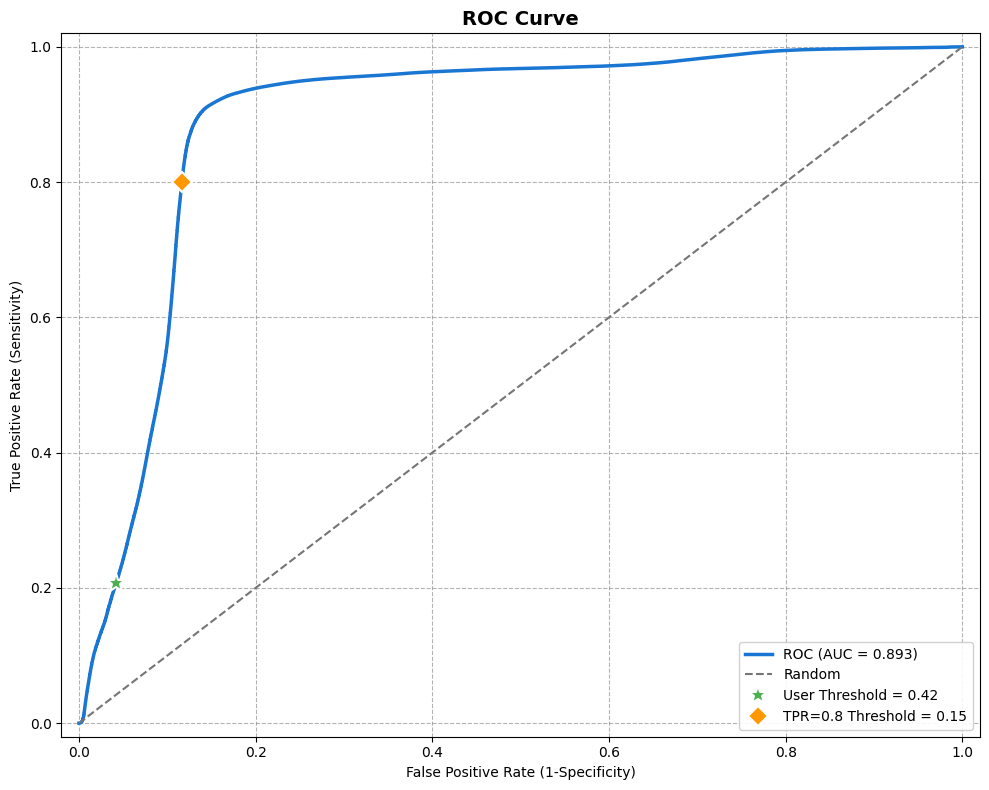

In [36]:
fig, ax, results = plot_roc_curve_from_model(
    model=model,
    test_loader=test_loader,
    device=device,
    threshold=calibrated_threshold,  # Your preferred threshold
    title="ROC Curve"
)

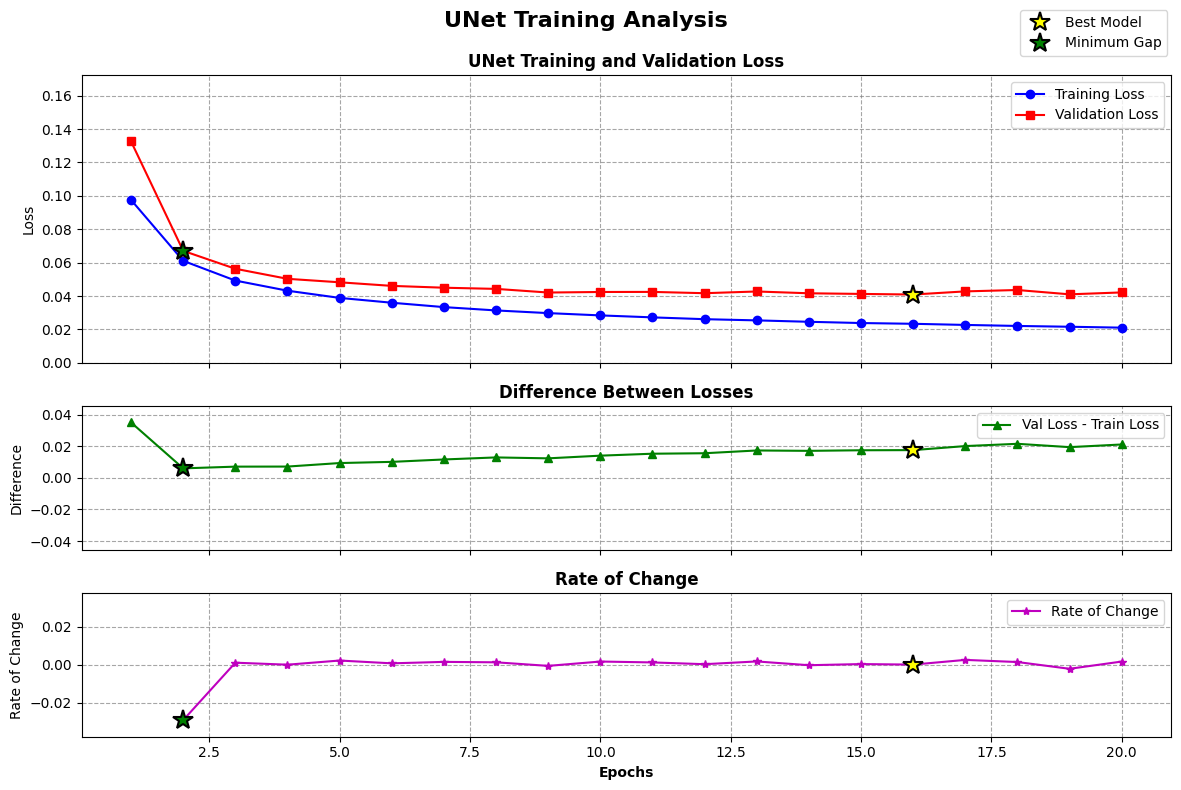

In [37]:
# Create figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1, 1]}, sharex=True)

# Extract and calculate data
epochs = range(1, len(history['train_loss']) + 1)
val_loss, train_loss = np.array(history['val_loss']), np.array(history['train_loss'])
diff = val_loss - train_loss
derivative = np.diff(diff)
derivative_epochs = epochs[1:]

# Find key metrics
best_epoch, min_gap_epoch = epochs[np.argmin(val_loss)], epochs[np.argmin(np.abs(diff))]

# Plot losses, difference, and derivative
axs[0].plot(epochs, train_loss, 'b-o', label='Training Loss')
axs[0].plot(epochs, val_loss, 'r-s', label='Validation Loss')
axs[1].plot(epochs, diff, 'g-^', label='Val Loss - Train Loss')
axs[2].plot(derivative_epochs, derivative, 'm-*', label='Rate of Change')

# Configure each subplot
titles = ['UNet Training and Validation Loss', 'Difference Between Losses', 'Rate of Change']
ylabels = ['Loss', 'Difference', 'Rate of Change']
for i, (ax, title, ylabel, data) in enumerate(zip(
        axs, titles, ylabels, [None, diff, derivative])):
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True, alpha=0.7)
    if i > 0:  # For difference and derivative plots
        max_val = max(abs(np.max(data)), abs(np.min(data)))
        ax.set_ylim(-max_val * 1.3, max_val * 1.3)
axs[0].set_ylim(0, max(np.max(train_loss), np.max(val_loss)) * 1.3)
axs[2].set_xlabel('Epochs', fontweight='bold')

# Mark key points with stars
key_points = [
    (best_epoch, 'yellow', 'Best Model'),
    (min_gap_epoch, 'green', 'Minimum Gap')
]

for epoch, color, _ in key_points:
    # Add stars to each plot
    axs[0].plot(epoch, val_loss[epoch-1], '*', ms=15, mfc=color, mec='black', mew=1.5)
    axs[1].plot(epoch, diff[epoch-1], '*', ms=15, mfc=color, mec='black', mew=1.5)
    if epoch > 1 and epoch-2 < len(derivative):
        axs[2].plot(epoch, derivative[epoch-2], '*', ms=15, mfc=color, mec='black', mew=1.5)

# Add legend for the stars
fig.legend([Line2D([0], [0], marker='*', color='w', mfc=color, mec='black', ms=15, mew=1.5)
          for _, color, _ in key_points],
          [label for _, _, label in key_points],
          loc='upper right', bbox_to_anchor=(0.99, 0.99))

# Final layout adjustments
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('UNet Training Analysis', fontsize=16, fontweight='bold', y=0.98)
plt.show()

## Error Checking

In [38]:
def visualize_positive_predictions(model, test_loader, device, threshold=0.5, num_samples=20, num_cols=5, min_positive_pixels=1):
    """
    Visualize samples that have positive pixels (1's) in the model's predictions.

    Args:
        model: The trained model
        test_loader: DataLoader for test data
        device: Device to run model on (cuda/cpu)
        threshold: Classification threshold for predictions (default: 0.5)
        num_samples: Number of samples with positive predictions to visualize
        num_cols: Number of columns in the visualization grid
        min_positive_pixels: Minimum number of predicted positive pixels required
    """
    model.eval()
    positive_samples = []
    batch_count = total_samples_checked = 0

    print(f"Looking for {num_samples} samples with positive pixels in model predictions...")
    print(f"Using classification threshold: {threshold:.4f} ({threshold*100:.1f}%)")

    # Collect samples with positive predictions
    for inputs, labels in test_loader:
        batch_count += 1
        batch_size = inputs.shape[0]
        total_samples_checked += batch_size

        # Move batch to device
        inputs_device = inputs.to(device)
        labels_device = labels.to(device)

        # Make predictions
        with torch.no_grad():
            outputs = model(inputs_device)
            # Get probabilities
            probs = outputs if hasattr(model, 'sigmoid') and model.sigmoid is not None else torch.sigmoid(outputs)
            # Apply threshold
            preds = (probs > threshold).float()

        # Check each sample in the batch for positive predictions
        for i in range(batch_size):
            # Count positive pixels in prediction
            # Use the same threshold value that was used to create the prediction
            positive_pixel_count = torch.sum(preds[i]).item()

            if positive_pixel_count >= min_positive_pixels:
                # Store all relevant data for this sample
                positive_samples.append({
                    'input': inputs[i],
                    'label': labels[i],
                    'prob': probs[i].cpu(),
                    'pred': preds[i].cpu(),
                    'pos_pixels': positive_pixel_count
                })

                print(f"Found sample with {positive_pixel_count} predicted positive pixels")

                if len(positive_samples) >= num_samples:
                    break

        if len(positive_samples) >= num_samples:
            break

        # Print progress update every 10 batches
        if batch_count % 10 == 0:
            print(f"Checked {batch_count} batches, {total_samples_checked} samples. Found {len(positive_samples)} samples with positive predictions so far.")

    print(f"Found {len(positive_samples)} samples with positive predictions after checking {batch_count} batches ({total_samples_checked} samples total)")

    # If we didn't find enough samples, use what we have
    num_samples = len(positive_samples)
    if num_samples == 0:
        print("No samples with positive predictions found!")
        return

    # Create visualization grid
    num_rows = (num_samples + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols*4, figsize=(num_cols*8, num_rows*2))
    axes_flat = axes.flatten() if num_rows > 1 or num_cols > 1 else [axes[0], axes[1], axes[2], axes[3]] if isinstance(axes, np.ndarray) else [axes]

    for i in range(num_samples):
        # Calculate indices for the four subplots for this sample
        idx_base = (i // num_cols) * (num_cols*4) + (i % num_cols) * 4

        # Get sample data
        sample = positive_samples[i]
        input_img = sample['input'][0].numpy()  # First channel
        label_img = sample['label'][0].numpy()
        prob_img = sample['prob'][0].numpy()
        pred_img = sample['pred'][0].numpy()

        # Count positive pixels in GT and prediction
        gt_pos_count = np.sum(label_img > 0.5)
        pred_pos_count = sample['pos_pixels']

        # Plot input, ground truth, probabilities, and prediction
        axes_flat[idx_base].imshow(input_img, cmap='gray')
        axes_flat[idx_base].set_title(f'S{i+1}: Input')
        axes_flat[idx_base].axis('off')

        axes_flat[idx_base+1].imshow(label_img, cmap='gray')
        axes_flat[idx_base+1].set_title(f'GT: {gt_pos_count} px')
        axes_flat[idx_base+1].axis('off')

        # Plot probability map with contours
        prob_display = axes_flat[idx_base+2].imshow(prob_img, cmap='plasma', vmin=0, vmax=min(threshold + 0.1, 1.0))
        # Add contours at specific thresholds
        contour_levels = [0.05, 0.1, 0.2]
        contours = axes_flat[idx_base+2].contour(prob_img, levels=contour_levels,
                                                 colors=['white', 'yellow', 'red'], linewidths=0.5)
        axes_flat[idx_base+2].set_title(f'Probs with contours')
        axes_flat[idx_base+2].axis('off')

        axes_flat[idx_base+3].imshow(pred_img, cmap='gray')
        axes_flat[idx_base+3].set_title(f'Pred > {threshold:.2f}: {pred_pos_count} px')
        axes_flat[idx_base+3].axis('off')

    # Hide unused subplots
    for i in range(num_samples*4, len(axes_flat)):
        axes_flat[i].axis('off')

    # First arrange all subplots with appropriate spacing
    plt.subplots_adjust(left=0.05, right=0.92, top=0.9, bottom=0.05, wspace=0.1, hspace=0.2)

    # Add colorbar for probabilities
    cbar_ax = fig.add_axes([0.94, 0.15, 0.01, 0.7])
    cbar = fig.colorbar(prob_display, cax=cbar_ax, label='Probability')

    # Add legend for contours
    contour_levels = [0.05, 0.1, 0.2]
    contour_colors = ['white', 'yellow', 'red']
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color=contour_colors[i], lw=1,
                             label=f'p = {contour_levels[i]}')
                     for i in range(len(contour_levels))]
    leg_ax = fig.add_axes([0.94, 0.05, 0.05, 0.1])
    leg_ax.legend(handles=legend_elements, loc='center', frameon=False)
    leg_ax.axis('off')

    # Add title without relying on tight_layout
    fig.suptitle(f'Samples with Positive Predictions (Threshold: {threshold:.4f}, Colormap Range: 0-{min(threshold + 0.1, 1.0):.2f})', fontsize=16, y=0.98)
    plt.show()

Looking for 10 samples with positive pixels in model predictions...
Using classification threshold: 0.4178 (41.8%)
Found sample with 1.0 predicted positive pixels
Found sample with 1.0 predicted positive pixels
Found sample with 1.0 predicted positive pixels
Found sample with 3.0 predicted positive pixels
Found sample with 1.0 predicted positive pixels
Found sample with 3.0 predicted positive pixels
Found sample with 1.0 predicted positive pixels
Found sample with 1.0 predicted positive pixels
Found sample with 1.0 predicted positive pixels
Found sample with 4.0 predicted positive pixels
Found 10 samples with positive predictions after checking 1 batches (512 samples total)


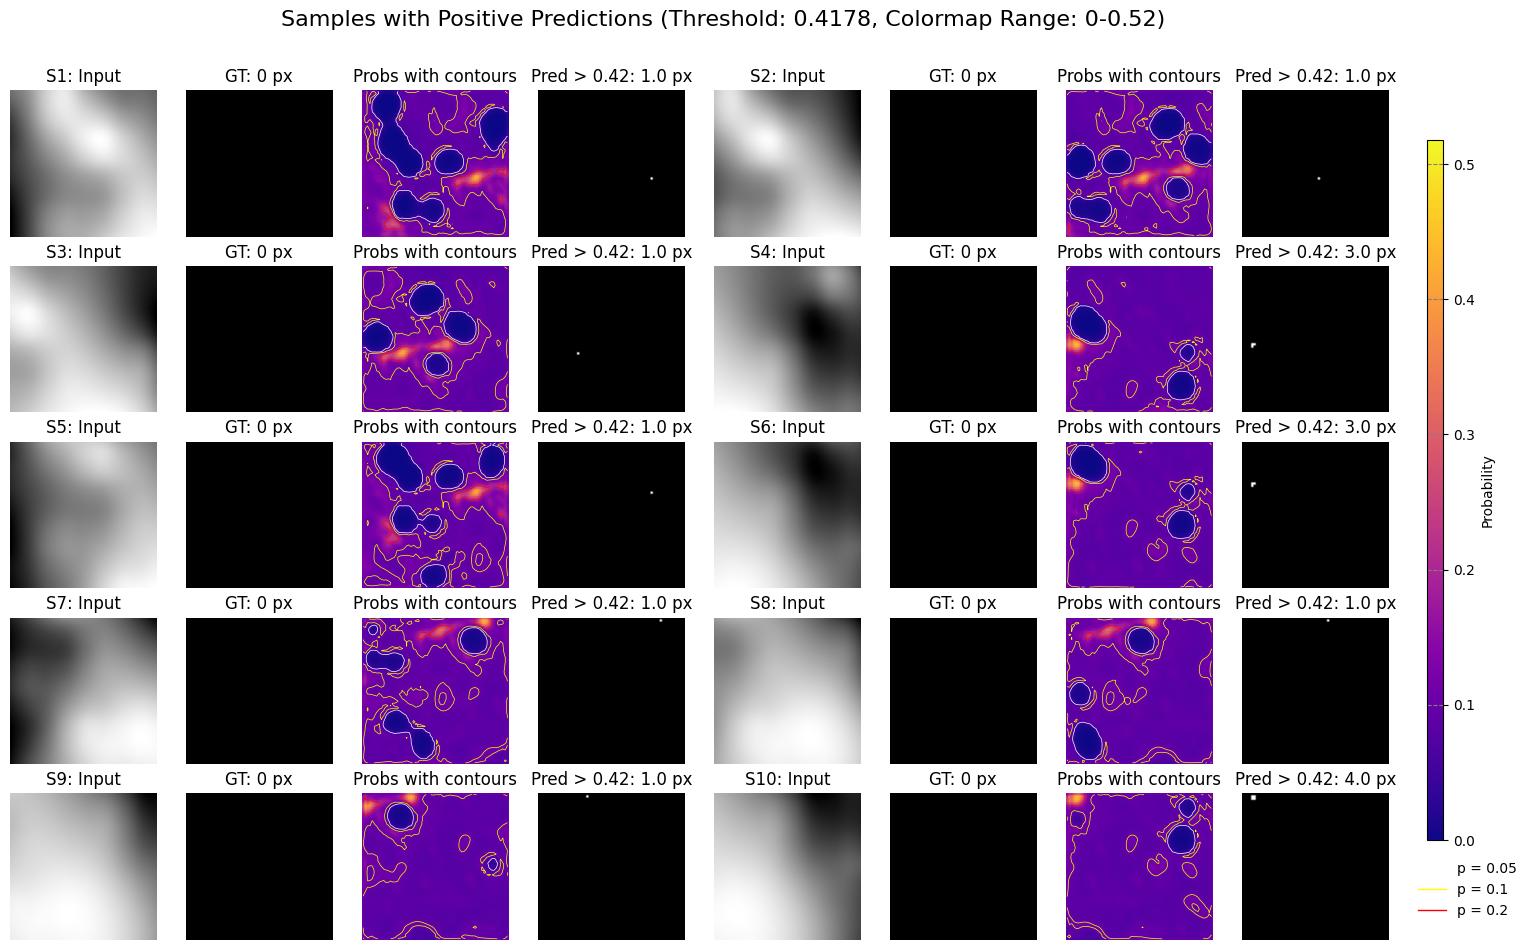

In [39]:
# Find and visualize 20 samples with at least 1 positive pixel
visualize_positive_predictions(
    model,
    test_loader,
    device,
    threshold=calibrated_threshold,  # Pass your calibrated threshold here
    num_samples=10,
    num_cols=2
)

In [40]:
def compare_gt_predictions(model, data_loader, device='cpu', threshold=0.5):
    """Compare distribution of positive pixels in ground truth vs model predictions."""
    model.eval()

    # Initialize counters
    stats = {k: {'pos_pixels': 0, 'samples_with_pos': 0, 'percentages': [], 'counts': []}
             for k in ['gt', 'pred']}
    total_pixels = total_samples = 0

    print(f"Analyzing class distribution using threshold: {threshold:.4f} ({threshold*100:.1f}%)...")

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(data_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            batch_size = labels.shape[0]
            total_samples += batch_size

            # Get model predictions
            outputs = model(inputs)
            probs = torch.sigmoid(outputs) if not hasattr(model, 'sigmoid') or model.sigmoid is None else outputs
            preds = (probs > threshold).float()

            # Process each sample in the batch
            for i in range(batch_size):
                label, pred = labels[i], preds[i]
                num_pixels = label.numel()
                total_pixels += num_pixels

                # Process ground truth and predictions
                for key, data in [('gt', label), ('pred', pred)]:
                    pos = torch.sum(data > 0.5).item()
                    stats[key]['pos_pixels'] += pos
                    stats[key]['counts'].append(pos)
                    stats[key]['percentages'].append((pos / num_pixels) * 100)
                    if pos > 0:
                        stats[key]['samples_with_pos'] += 1

            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx + 1} batches, {total_samples} samples so far")

    # Calculate percentages and create histogram data
    count_bins = [0, 1, 10, 100, 1000, 10000, 100000]
    percentage_bins = [0, 0.01, 0.1, 1, 5, 10, 25, 50, 100]
    count_labels = ["0", "1-9", "10-99", "100-999", "1K-9.9K", "10K+"]
    percentage_labels = ["0%", "0-0.01%", "0.01-0.1%", "0.1-1%", "1-5%", "5-10%", "10-25%", "25-50%", "50%+"]

    for key in stats:
        # Calculate overall percentages
        stats[key]['pos_percentage'] = (stats[key]['pos_pixels'] / total_pixels) * 100
        stats[key]['samples_with_pos_percentage'] = (stats[key]['samples_with_pos'] / total_samples) * 100

        # Create histograms
        stats[key]['count_hist'], _ = np.histogram(stats[key]['counts'], bins=count_bins)
        stats[key]['percentage_hist'], _ = np.histogram(stats[key]['percentages'], bins=percentage_bins)

        # Ensure histograms match label lengths
        if len(stats[key]['count_hist']) != len(count_labels):
            stats[key]['count_hist'] = np.resize(stats[key]['count_hist'], len(count_labels))
        if len(stats[key]['percentage_hist']) != len(percentage_labels):
            stats[key]['percentage_hist'] = np.resize(stats[key]['percentage_hist'], len(percentage_labels))

    # Visualize the distributions
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    bar_width = 0.35

    # Plot histograms
    for idx, (title, xlabel, bins_labels, hist_key) in enumerate([
        ("Distribution of Positive Pixel Counts", "Number of Positive Pixels", count_labels, 'count_hist'),
        ("Distribution of Positive Pixel Percentages", "Percentage of Positive Pixels", percentage_labels, 'percentage_hist')
    ]):
        x = np.arange(len(bins_labels))
        axs[idx].bar(x - bar_width/2, stats['gt'][hist_key], bar_width,
                   label='Ground Truth', color='skyblue', edgecolor='black')
        axs[idx].bar(x + bar_width/2, stats['pred'][hist_key], bar_width,
                   label=f'Predictions (thresh={threshold:.2f})', color='salmon', edgecolor='black')

        axs[idx].set_title(title, fontsize=14)
        axs[idx].set_xlabel(xlabel, fontsize=12)
        axs[idx].set_ylabel("Number of Samples", fontsize=12)
        axs[idx].set_xticks(x)
        axs[idx].set_xticklabels(bins_labels)
        axs[idx].legend(fontsize=12)
        axs[idx].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.suptitle(f"Class Distribution Analysis (Threshold: {threshold:.4f})", fontsize=16, y=0.98)
    plt.subplots_adjust(top=0.9)
    plt.show()

    # Print statistics
    print(f"\n{'='*80}")
    print(f"CLASS DISTRIBUTION COMPARISON (Threshold: {threshold:.4f} or {threshold*100:.1f}%)")
    print(f"{'='*80}")
    print(f"Total samples: {total_samples}")
    print(f"Total pixels: {total_pixels:,}")

    for label, key in [("Ground Truth", 'gt'), ("Prediction", 'pred')]:
        print(f"\n{label} Statistics:")
        print(f"  Positive pixels: {stats[key]['pos_pixels']:,} ({stats[key]['pos_percentage']:.4f}%)")
        print(f"  Negative pixels: {total_pixels - stats[key]['pos_pixels']:,} ({100 - stats[key]['pos_percentage']:.4f}%)")
        print(f"  Samples with positives: {stats[key]['samples_with_pos']} ({stats[key]['samples_with_pos_percentage']:.2f}%)")

    print("\nHistogram Counts (GT vs Pred):")
    for i, label in enumerate(count_labels):
        print(f"  {label}: {stats['gt']['count_hist'][i]} vs {stats['pred']['count_hist'][i]}")

    print("\nHistogram Percentages (GT vs Pred):")
    for i, label in enumerate(percentage_labels):
        print(f"  {label}: {stats['gt']['percentage_hist'][i]} vs {stats['pred']['percentage_hist'][i]}")

    # Return statistics
    return {
        "threshold": threshold,
        "total_samples": total_samples,
        "ground_truth": {
            "positive_pixels": stats['gt']['pos_pixels'],
            "positive_percentage": stats['gt']['pos_percentage'],
            "samples_with_positives": stats['gt']['samples_with_pos'],
            "samples_with_positives_percentage": stats['gt']['samples_with_pos_percentage'],
            "count_histogram": stats['gt']['count_hist'].tolist(),
            "percentage_histogram": stats['gt']['percentage_hist'].tolist()
        },
        "predictions": {
            "positive_pixels": stats['pred']['pos_pixels'],
            "positive_percentage": stats['pred']['pos_percentage'],
            "samples_with_positives": stats['pred']['samples_with_pos'],
            "samples_with_positives_percentage": stats['pred']['samples_with_pos_percentage'],
            "count_histogram": stats['pred']['count_hist'].tolist(),
            "percentage_histogram": stats['pred']['percentage_hist'].tolist()
        }
    }

Analyzing class distribution using threshold: 0.4178 (41.8%)...
Processed 10 batches, 5096 samples so far


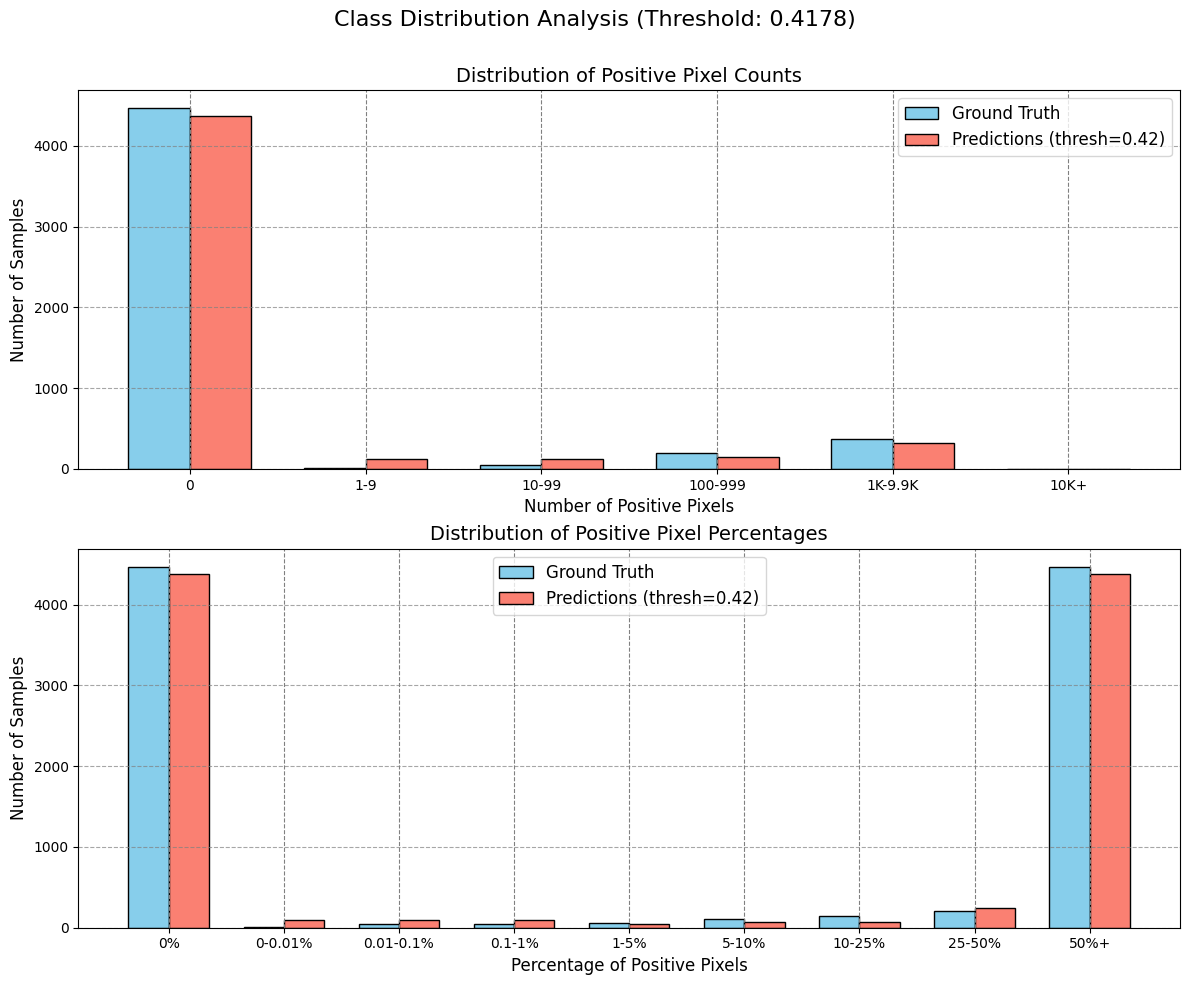


CLASS DISTRIBUTION COMPARISON (Threshold: 0.4178 or 41.8%)
Total samples: 5096
Total pixels: 20,873,216

Ground Truth Statistics:
  Positive pixels: 977,968 (4.6853%)
  Negative pixels: 19,895,248 (95.3147%)
  Samples with positives: 629 (12.34%)

Prediction Statistics:
  Positive pixels: 1,043,660 (5.0000%)
  Negative pixels: 19,829,556 (95.0000%)
  Samples with positives: 723 (14.19%)

Histogram Counts (GT vs Pred):
  0: 4467 vs 4373
  1-9: 14 vs 126
  10-99: 50 vs 128
  100-999: 198 vs 151
  1K-9.9K: 367 vs 318
  10K+: 0 vs 0

Histogram Percentages (GT vs Pred):
  0%: 4467 vs 4373
  0-0.01%: 4 vs 101
  0.01-0.1%: 40 vs 90
  0.1-1%: 52 vs 101
  1-5%: 60 vs 44
  5-10%: 114 vs 74
  10-25%: 146 vs 66
  25-50%: 213 vs 247
  50%+: 4467 vs 4373


In [41]:
distribution_stats = compare_gt_predictions(
    model,
    test_loader,
    device,
    threshold=calibrated_threshold
)

## Now let's process the whole image

In [55]:
def predict_full_image(model, dataset_input, device, patch_size=64, stride=32, threshold=0.5,
                      visualize=True, normalize_func=None, normalize_stats=None,
                      mask=None, verbose=False, viz_channel=0, smoothing_sigma=1.0):
    """Apply model to full image using sliding window approach."""
    def interpolate_nans(img):
        # Find NaN locations
        nan_mask = np.isnan(img)
        if not np.any(nan_mask): return img  # No NaNs to fill

        # Get valid data mask
        valid_mask = ~nan_mask
        if not np.any(valid_mask): return np.zeros_like(img)  # All NaNs, return zeros

        # Calculate mean of valid data
        mean_val = np.mean(img[valid_mask])
        filled = np.copy(img); filled[nan_mask] = mean_val  # First fill with mean

        # Distance-based interpolation
        dist = ndimage.distance_transform_edt(nan_mask)  # Distance to nearest valid pixel
        max_dist = np.max(dist)
        if max_dist > 0:
            # Create weight map based on distance
            wt = np.exp(-dist / (max_dist/3))

            # Smooth interpolation from valid data to mean
            tmp = np.copy(img); tmp[nan_mask] = mean_val
            smooth = ndimage.gaussian_filter(tmp, sigma=2)
            smooth[valid_mask] = img[valid_mask]  # Keep original valid values

            # Blend based on distance
            filled = smooth * wt + mean_val * (1 - wt)
        return filled

    # Set model to evaluation mode
    model.eval()

    # Handle input data - either load image file or use numpy array
    img_np = np.array(Image.open(dataset_input).convert('L')) / 255.0 if isinstance(dataset_input, str) else np.array(dataset_input, copy=True)
    print(f"Dataset input shape: {img_np.shape}")

    # Validate input dimensions
    if len(img_np.shape) == 1 or (len(img_np.shape) == 2 and min(img_np.shape) == 1):
        raise ValueError(f"Invalid image shape: {img_np.shape}")

    # Calculate NaN statistics from original data
    raw_nan_mask = np.isnan(img_np)
    if len(raw_nan_mask.shape) == 3:
        raw_nan_mask = np.any(raw_nan_mask, axis=0)  # Collapse channels for visualization

    raw_nan_mask = np.copy(raw_nan_mask)
    raw_nan_count = np.sum(raw_nan_mask)
    total_px = raw_nan_mask.size
    print(f"NaN statistics: {raw_nan_count}/{total_px} pixels ({raw_nan_count/total_px*100:.2f}%)")

    # Handle image dimensions and channel format
    is_multichannel = len(img_np.shape) > 2

    if is_multichannel:
        if img_np.shape[0] <= img_np.shape[1] and img_np.shape[0] <= img_np.shape[2]:
            # Format: (channels, height, width)
            n_ch, h, w = img_np.shape
            viz_ch_idx = min(max(0, viz_channel), n_ch-1)
            viz_img = np.copy(img_np[viz_ch_idx])
        else:
            # Format: (height, width, channels)
            h, w, n_ch = img_np.shape
            img_np = np.transpose(img_np, (2, 0, 1))  # Convert to (channels, height, width)
            viz_ch_idx = min(max(0, viz_channel), n_ch-1)
            viz_img = np.copy(img_np[viz_ch_idx])
    else:
        # Single channel image
        h, w = img_np.shape
        n_ch = 1
        img_np = img_np.reshape(1, h, w)  # Add channel dimension
        viz_img = np.copy(img_np[0])

    if verbose:
        print(f"Image: {n_ch} channels, {h}x{w}")

    # Store original data masks
    orig_nan_mask = np.isnan(img_np)
    viz_nan_mask = np.copy(raw_nan_mask if len(orig_nan_mask.shape) == 3 else orig_nan_mask)

    # Apply mask if provided (useful for limiting prediction area)
    if mask is not None:
        if mask.shape[-2:] != img_np.shape[-2:]:
            raise ValueError(f"Mask shape mismatch: {mask.shape} vs {img_np.shape[-2:]}")

        binary_mask = mask > 0
        if len(binary_mask.shape) == 2 and len(img_np.shape) == 3:
            binary_mask = np.expand_dims(binary_mask, 0).repeat(n_ch, axis=0)

        # Apply mask to each channel - set invalid areas to NaN
        for c in range(n_ch):
            img_np[c][~(binary_mask[c] if len(binary_mask.shape) == 3 else binary_mask)] = np.nan

    # Create working copy and record original NaN locations
    work_img = np.copy(img_np)
    orig_nan_2d = np.isnan(work_img[0] if n_ch > 1 else work_img)

    # Fill NaNs with interpolation for processing
    print("Filling NaNs...")
    for c in range(n_ch):
        work_img[c] = interpolate_nans(work_img[c])

    # Apply normalization if provided
    if normalize_func:
        if verbose: print("Normalizing data...")
        # Reshape for batch processing, then apply normalization
        work_img = normalize_func(work_img.reshape(1, *work_img.shape),
                      calculate_stats=False, stats=normalize_stats,
                      show_progress=False)[0] if normalize_stats else normalize_func(
                      work_img.reshape(1, *work_img.shape), show_progress=False)[0]

    # Create output maps for prediction
    prob_map = np.zeros((h, w), dtype=np.float32)  # Probability map
    count_map = np.zeros((h, w), dtype=np.float32)  # Count for averaging overlapping patches

    # Calculate patch grid dimensions
    patches_h = max(1, (h - patch_size) // stride + 1)
    patches_w = max(1, (w - patch_size) // stride + 1)
    total_patches = patches_h * patches_w

    print(f"Processing {total_patches} patches ({patch_size}×{patch_size})...")

    # Process image with sliding window approach
    row_iter = tqdm(range(0, max(h - patch_size + 1, 1), stride),
                  desc="Rows", total=patches_h) if verbose else range(0, max(h - patch_size + 1, 1), stride)

    for y in row_iter:
        for x in range(0, max(w - patch_size + 1, 1), stride):
            # Extract patch at current position
            patch = np.copy(work_img[:, y:min(y+patch_size, h), x:min(x+patch_size, w)])

            # Handle boundary patches (pad if needed)
            if patch.shape[1] < patch_size or patch.shape[2] < patch_size:
                tmp = np.zeros((n_ch, patch_size, patch_size), dtype=np.float32)
                tmp[:, :patch.shape[1], :patch.shape[2]] = patch
                patch = tmp

            # Run model prediction
            with torch.no_grad():
                output = model(torch.from_numpy(patch).float().unsqueeze(0).to(device))
                prob = output if hasattr(model, 'sigmoid') and model.sigmoid else torch.sigmoid(output)

            # Update probability and count maps
            prob_np = prob[0, 0].cpu().numpy()
            ph, pw = min(patch_size, h - y), min(patch_size, w - x)
            prob_map[y:y+ph, x:x+pw] += prob_np[:ph, :pw]
            count_map[y:y+ph, x:x+pw] += 1

    # Average overlapping regions
    count_map[count_map == 0] = 1  # Avoid division by zero
    prob_map /= count_map

    if verbose:
        print("Post-processing results...")

    # Apply smoothing and threshold
    smooth_map = ndimage.gaussian_filter(prob_map, sigma=smoothing_sigma)
    pred_map = (prob_map > threshold).astype(np.float32)

    # Restore original NaN values in all result maps
    for m in [smooth_map, prob_map, pred_map]:
        m[orig_nan_2d] = np.nan

    # Calculate statistics for reporting
    valid_px = ~viz_nan_mask
    pos_count = np.sum((pred_map > 0.5) & valid_px)  # Positive pixels in valid data
    valid_count = np.sum(valid_px)
    percentage = (pos_count / valid_count * 100) if valid_count else 0

    # Calculate final NaN statistics
    nan_count = np.sum(viz_nan_mask)
    print(f"Final NaNs: {nan_count}/{h*w} ({nan_count/(h*w)*100:.2f}%)")

    # Check if NaN count changed (warning)
    if nan_count != raw_nan_count:
        print(f"WARNING: NaN count changed! Original: {raw_nan_count}, Current: {nan_count}")

    # Generate visualization if requested
    if visualize:
        fig, axes = plt.subplots(2, 2, figsize=(16, 16))
        axes = axes.flatten()

        # Plot 1: Input image
        vmin, vmax = np.nanmin(viz_img), np.nanmax(viz_img)
        im0 = axes[0].imshow(np.nan_to_num(viz_img), cmap='viridis', vmin=vmin, vmax=vmax)

        # Create NaN overlay for all plots (white with alpha)
        nan_overlay = np.zeros((h, w, 4))
        nan_overlay[viz_nan_mask] = [1, 1, 1, 1]  # White with alpha=1
        axes[0].imshow(nan_overlay)

        axes[0].set_title(f'Input (Channel {viz_ch_idx})' if is_multichannel else 'Input')
        axes[0].axis('off')
        fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

        # Plot 2: Land vs Water visualization
        land_water = np.ones((h, w, 3))
        land_water[~viz_nan_mask] = [0.824, 0.706, 0.549]  # Tan color for land
        land_water[viz_nan_mask] = [0.118, 0.565, 1.0]     # Blue color for water

        axes[1].imshow(land_water)
        axes[1].set_title(f'Land vs Water\nWater: {nan_count} px ({nan_count/(h*w)*100:.2f}%)')
        axes[1].axis('off')

        # Add legend for land/water
        axes[1].legend(handles=[
            mpatches.Patch(color=[0.824, 0.706, 0.549], label='Land (Valid Data)'),
            mpatches.Patch(color=[0.118, 0.565, 1.0], label='Water (NaN)')
        ], loc='lower right')

        # Plot 3: Probability map with contour
        max_prob = np.nanmax(smooth_map)
        cbar_max = np.round((max_prob + 0.05) * 20) / 20  # Round to nearest 0.05

        im2 = axes[2].imshow(np.nan_to_num(smooth_map), cmap='plasma', vmin=0, vmax=cbar_max)
        axes[2].imshow(nan_overlay)
        axes[2].set_title(f'Probability Map [0, {cbar_max:.2f}]')
        axes[2].axis('off')

        # Add threshold contour (avoiding NaN regions)
        contour_data = np.copy(smooth_map)
        contour_data[viz_nan_mask] = -1  # Set NaNs below threshold
        axes[2].contour(contour_data, levels=[threshold], colors='black', linewidths=1.5)
        fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

        # Plot 4: Binary prediction map
        im3 = axes[3].imshow(np.nan_to_num(pred_map), cmap='gray')
        axes[3].imshow(nan_overlay)
        axes[3].set_title(f'Prediction (Threshold: {threshold:.2f})')
        axes[3].axis('off')
        fig.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

        # Set overall title with summary statistics
        plt.suptitle(f'Predicted: {pos_count} positive pixels ({percentage:.2f}%)', fontsize=16)
        plt.tight_layout()
        plt.show()

    if verbose:
        print(f"Done. Result: {pos_count} positive pixels ({percentage:.2f}%).")

    return smooth_map, pred_map

Dataset input shape: (7, 2633, 1876)
NaN statistics: 936560/4939508 pixels (18.96%)
Filling NaNs...
Processing data with 7 channels

--- Channel Statistics Before Normalization ---
Channel 0: min=-525.749, max=2294.860, mean=-162.590, median=-162.589
Channel 1: min=-21.784, max=50.318, mean=-0.001, median=-0.001
Channel 2: min=-0.563, max=4.737, mean=0.837, median=0.837
Channel 3: min=-2362.806, max=4813.387, mean=-24.952, median=-36.753
Channel 4: min=-0.709, max=13.529, mean=1.471, median=1.471
Channel 5: min=-49847.531, max=336924.656, mean=-54.026, median=-54.633
Channel 6: min=-1.843, max=59.127, mean=7.106, median=7.110

--- Channel Statistics After Normalization ---
Channel 0: min=-5.392, max=35.667, mean=-0.106, median=-0.106
Channel 1: min=-47.210, max=109.056, mean=-0.001, median=-0.001
Channel 2: min=-2.681, max=7.228, mean=-0.063, median=-0.063
Channel 3: min=-28.708, max=59.554, mean=0.046, median=-0.099
Channel 4: min=-3.292, max=17.071, mean=-0.175, median=-0.174
Channel

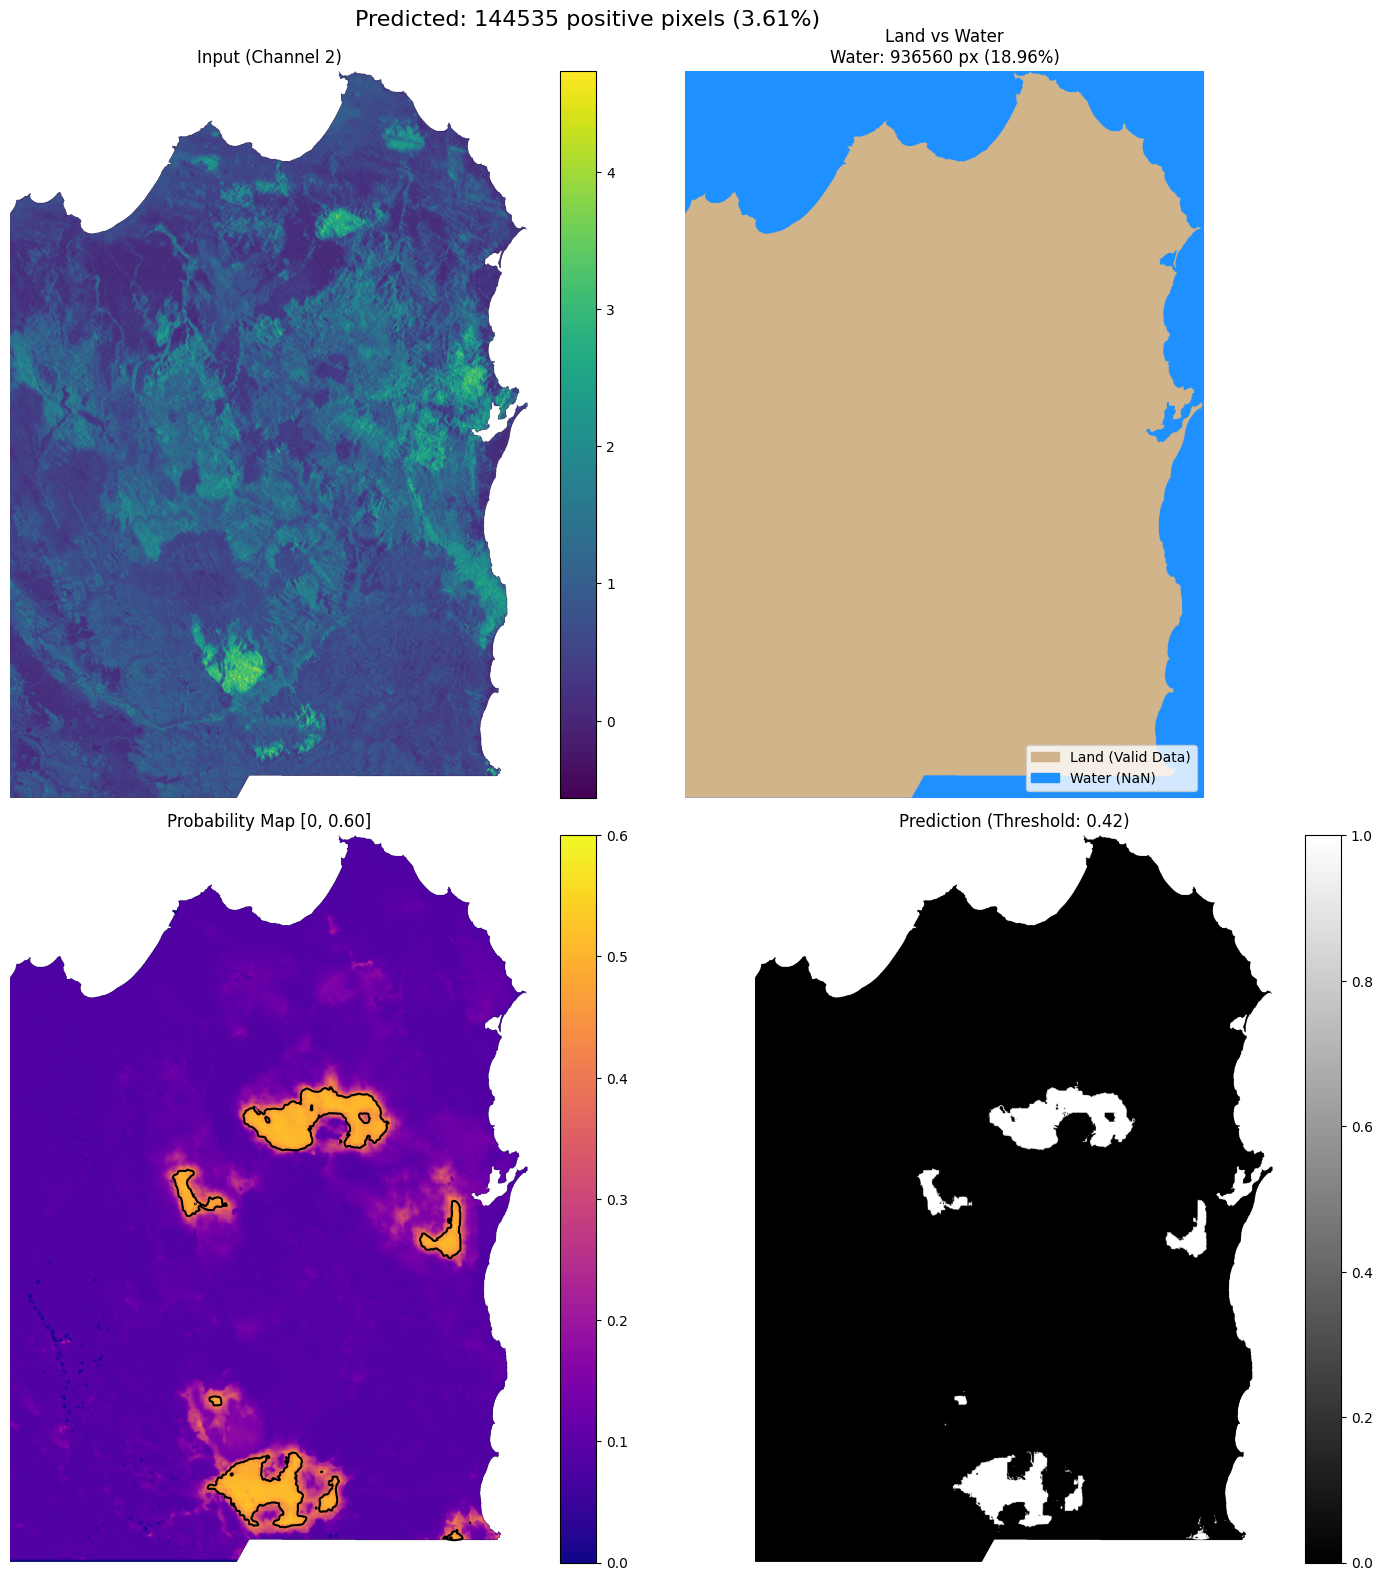

In [56]:
smooth_prob_map, pred_map = predict_full_image(
    model=model,
    dataset_input=entire_input_ds,
    device=device,
    patch_size=64,
    stride=16,
    threshold=calibrated_threshold,
    normalize_func=normalize_channels_for_binary_unet,
    normalize_stats=norm_stats,
    verbose=False,
    viz_channel=2,  # Visualize the 3rd channel (0-indexed)
    smoothing_sigma=2.0
)